<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h2>Modeling Case Study in the Chicago Bike Share Industry</h2>
<h3>DAT-5390 | Computational Data Analytics with Python</h3>

Author: [Constantin Leo Alexander Wiese](https://www.linkedin.com/in/cla-wiese/)

Hult International Business School

February, 2024

The burgeoning bike-sharing sector in Chicago is an intriguing focus for data analytics, merging urban transportation dynamics with technological advancements. This case study tackles the challenge of forecasting daily bike rental volumes by employing a dataset enriched with environmental and temporal variables. The objective is to construct a predictive model capable of discerning the factors influencing bike rental demand. For the Cook County Planning and Development Department, the project aims to augment urban planning efforts and deepen the understanding of transportation trends. The research navigates the dataset's complexities by conducting comprehensive exploratory data analysis, advanced feature engineering, and deploying multiple linear modeling techniques. It endeavors to craft a narrative beyond mere statistics to offer actionable insights. The data preprocessing, model creation, and analytical reasoning methodology underscores data science's critical role in evolving urban mobility, promoting data-informed decision-making within Chicago's vibrant bike-sharing ecosystem.

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<h2>Installing Libraries, Loading, & Preparing Dataset</h2><br>

In [1]:
# importing libraries
import warnings                       # suppressing warnings
import numpy as np                    # mathematical essentials
import pandas as pd                   # data science essentials
import matplotlib.pyplot as plt       # essential graphical output
import seaborn as sns                 # enhanced graphical output
from sklearn.tree import plot_tree    # tree plots
import statsmodels.formula.api as smf # linear modeling with p values
import sklearn.linear_model           # faster linear models
from sklearn.neighbors import KNeighborsRegressor # KNN for Regression
from sklearn.tree import DecisionTreeRegressor    # decision tree models
from sklearn.preprocessing import StandardScaler  # standard scaler
from sklearn.model_selection import train_test_split # train/test split
from sklearn.model_selection import RandomizedSearchCV # hyperparameter tuning

# Suppressing warnings
warnings.filterwarnings("ignore")

In [2]:
# setting pandas print options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

chicago = "./chicago_training_data.xlsx" # specifying file paths

df = pd.read_excel(io         = chicago,
                   sheet_name = "train",
                   header     = 0,
                   index_col  = "ID") # reading file into Python

df.head(n = 4) # checking first values

,DateHour,Temperature(F),Humidity(%),Wind speed (mph),Visibility(miles),DewPointTemperature(F),Rainfall(in),Snowfall(in),SolarRadiation(MJ/m2),Holiday,FunctioningDay,RENTALS
ID,,,,,,,,,,,,
mb_1039,2023-10-14 05:59:54.810,52,81,0.4,2.9,46.4,0.0,0.0,0.00,No,Yes,519
mb_1330,2023-10-26 08:59:53.355,51,53,2.2,NaN,35.2,0.0,0.0,1.01,No,Yes,1251
mb_551,2023-09-23 21:59:57.250,56,49,2.5,3.4,38.8,0.0,0.0,0.00,No,Yes,1685
mb_2103,2023-12-19 14:00:00.000,69,32,9.8,12.4,38.7,0.0,0.0,2.36,No,No,0


In [3]:
# renaming columns in a better format
df.columns = ["DateHour",              # to be transformed
              "Temperature",           # in Fahrenheit
              "Humidity",              # in percent
              "WindSpeed",             # in miles per hour
              "Visibility",            # in miles
              "DewPointTemperature",   # in Fahrenheit
              "Rainfall",              # in inches
              "Snowfall",              # in inches
              "SolarRadiation",        # in MJ/m2
              "Holiday",               # boolean
              "FunctioningDay",        # boolean
              "Rentals"]               # dependent feature

In [4]:
print(f"""
Original Dataset Size
------------------------
Observations (rows): {df.shape[0]}
Features (columns) : {df.shape[1]}
""") # formatting and printing the dimensions of the dataset


Original Dataset Size
------------------------
Observations (rows): 1638
Features (columns) : 12



In [5]:
# identifying missing observation values in incomplete features
print(f"""
Missing Observations
-------------------------""")
print(len(df) - df.count()[df.count() != len(df)])


Missing Observations
-------------------------
Visibility             63
DewPointTemperature    51
SolarRadiation         80
dtype: int64


<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<h2>Exploratory Data Analysis</h2>
<h3>Flagging Missing Values</h3><br>

In [6]:
for col in df.columns:  # looping to flag features with missing values
    if df[col].isnull().sum() > 0: # checking if the column has missing values
        # Create a new column with 'm_' prefix indicating missing values
        df["m_" + col] = df[col].isnull().astype(int)

The absence of data within a dataset does not render it useless; on the contrary, missing values can yield significant insights valuable for comprehensive data analysis. To capitalize on the information latent within missing data, creating dummy variables for features with absent values is a strategic approach, ensuring that the nuanced information conveyed by these omissions is preserved before imputation. This methodology is relevant in Visibility, DewPointTemperature, and SolarRadiation, where missing values are evident.

In [7]:
df.info() # checking EDA needs

<class 'pandas.core.frame.DataFrame'>
Index: 1638 entries, mb_1039 to mb_1747
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   DateHour               1638 non-null   datetime64[ns]
 1   Temperature            1638 non-null   int64         
 2   Humidity               1638 non-null   int64         
 3   WindSpeed              1638 non-null   float64       
 4   Visibility             1575 non-null   float64       
 5   DewPointTemperature    1587 non-null   float64       
 6   Rainfall               1638 non-null   float64       
 7   Snowfall               1638 non-null   float64       
 8   SolarRadiation         1558 non-null   float64       
 9   Holiday                1638 non-null   object        
 10  FunctioningDay         1638 non-null   object        
 11  Rentals                1638 non-null   int64         
 12  m_Visibility           1638 non-null   int64         
 13 

<h3>Extracting Time Data</h3>

Decomposing the DateTime into distinct columns for year, month, week, day, weekday, hour, minute, second, night, morning, afternoon, and evening enhances the granularity of temporal analysis, enabling a thorough investigation into how various time dimensions affect the dataset's observed trends and patterns. While including minute and second resolutions aims to provide a comprehensive temporal framework, their necessity for the analysis warrants further consideration, given their potential limited impact on deriving meaningful insights. The extraction of the week number and weekday is instrumental in elucidating weekly cyclical patterns or assessing the influence of specific days, which is particularly pertinent for analyzing data with temporal dependencies, such as rental activity. This methodological approach to feature engineering is indispensable in time series analyses or scenarios where temporal factors are integral to comprehending the dynamics within the dataset.

In [8]:
# extract desired components
df["Year"] = df["DateHour"].dt.year               # year
df["Month"] = df["DateHour"].dt.month             # month
df["Week"] = df["DateHour"].dt.isocalendar().week.astype("int32") # week
df["Day"] = df["DateHour"].dt.day                 # day (1 to 31)
df["Weekday"] = df["DateHour"].dt.weekday         # Monday=0, ... to Sunday=6
df["Hour"] = df["DateHour"].dt.hour               # hour (0-23)
df["Minute"] = df["DateHour"].dt.minute           # likely too narrow
df["Second"] = df["DateHour"].dt.second           # likely too narrow

# Creating binary variables for each time of day
df["Night"] = df["Hour"].apply(lambda x: 1 if 0 <= x < 6 else 0)
df["Morning"] = df["Hour"].apply(lambda x: 1 if 6 <= x < 12 else 0)
df["Afternoon"] = df["Hour"].apply(lambda x: 1 if 12 <= x < 18 else 0)
df["Evening"] = df["Hour"].apply(lambda x: 1 if 18 <= x < 24 else 0)

In [9]:
# Checking Representation of distribution - is n > 30?
times = ["Year", "Month", "Week", "Day", "Weekday", "Hour", "Minute", "Second",
         "Night", "Morning", "Afternoon", "Evening"]
for col in times:
    counts = df[col].value_counts().sort_index()
    print(f"{col} Counts:\n{counts.to_string(header = False)}\n")

Year Counts:
2023    1638

Month Counts:
9     542
10    554
11    146
12    396

Week Counts:
35     56
36    121
37    125
38    129
39    126
40    127
41    127
42    123
43    128
44     34
47     72
48    129
49    132
50    120
51     89

Day Counts:
1     53
2     58
3     52
4     52
5     56
6     51
7     55
8     51
9     56
10    58
11    57
12    47
13    54
14    50
15    58
16    52
17    51
18    56
19    51
20    56
21    54
22    54
23    54
24    53
25    58
26    54
27    58
28    52
29    54
30    54
31    19

Weekday Counts:
0    225
1    233
2    226
3    222
4    263
5    240
6    229

Hour Counts:
0     71
1     66
2     63
3     70
4     73
5     71
6     70
7     66
8     65
9     64
10    63
11    67
12    66
13    69
14    67
15    70
16    64
17    73
18    73
19    70
20    65
21    71
22    73
23    68

Minute Counts:
0      544
59    1094

Second Counts:
0     544
52     44
53    152
54    149
55    151
56    151
57    153
58    148
59    146

Night Co

The dataset encompasses temporal data from the latter third of 2023, spanning September to December. It exhibits a high frequency of representation across various time dimensions: weekly instances exceed 30 occurrences, daily figures (except the sum of the 31st days of any given month) are similarly abundant with over 30 repetitions, and hourly data points are notably consistent, each hour represented over 60 times. The distribution among weekdays is remarkably balanced, each with a count exceeding 200, ensuring an even temporal spread. However, the dataset's granularity diminishes at finer time scales; minute and second intervals are incompletely captured, with minutes concentrated at the extremes (0 and 59) and seconds displaying a skewed distribution towards specific values (52-59). All day times are sufficiently available.

In [10]:
df.drop("Year", inplace = True, axis = 1) # dropping year column as it only has 2023 values
df.head(n = 4) # verifying recent code snippets

,DateHour,Temperature,Humidity,WindSpeed,Visibility,DewPointTemperature,Rainfall,Snowfall,SolarRadiation,Holiday,FunctioningDay,Rentals,m_Visibility,m_DewPointTemperature,m_SolarRadiation,Month,Week,Day,Weekday,Hour,Minute,Second,Night,Morning,Afternoon,Evening
ID,,,,,,,,,,,,,,,,,,,,,,,,,,
mb_1039,2023-10-14 05:59:54.810,52,81,0.4,2.9,46.4,0.0,0.0,0.00,No,Yes,519,0,0,0,10,41,14,5,5,59,54,1,0,0,0
mb_1330,2023-10-26 08:59:53.355,51,53,2.2,NaN,35.2,0.0,0.0,1.01,No,Yes,1251,1,0,0,10,43,26,3,8,59,53,0,1,0,0
mb_551,2023-09-23 21:59:57.250,56,49,2.5,3.4,38.8,0.0,0.0,0.00,No,Yes,1685,0,0,0,9,38,23,5,21,59,57,0,0,0,1
mb_2103,2023-12-19 14:00:00.000,69,32,9.8,12.4,38.7,0.0,0.0,2.36,No,No,0,0,0,0,12,51,19,1,14,0,0,0,0,1,0


<h3>Creating Visualization Functions</h3><br>
Several functions are defined at this juncture to minimize the coding effort required for generating graphical outputs.

In [11]:
df_mv = df.copy(deep = True) # saving original data

# creating functions to ease data exploration
def histplot(feature):
    # setting figure size
    fig, ax = plt.subplots(figsize = (15, 4))
    
    # developing a histplot
    sns.histplot(data = df, x = feature, fill = True)

    # mean and median lines
    plt.axvline(x = df[feature].mean(), color = "red", label = "Mean", alpha = 0.5)
    plt.axvline(x = df[feature].median(), color = "blue", label = "Median", alpha = 0.5)

    # adding legend to the plot
    plt.legend()

    # displaying the plot
    plt.tight_layout()
    plt.show()
    
def boxplot(feature, feature_2):
    # setting figure size
    fig, ax = plt.subplots(figsize = (15, 4))
    
    # developing a histplot
    sns.boxplot(data = df, x = feature, y = feature_2)

    # displaying the plot
    plt.tight_layout()
    plt.show()
    
def scatterplot(feature, feature_2):
    # setting figure size
    fig, ax = plt.subplots(figsize = (15, 4))
    
    # developing a histplot
    sns.scatterplot(data = df, x = feature, y = feature_2)

    # displaying the plot
    plt.tight_layout()
    plt.show()
    
def imputation_check(feature):
    # setting figure size
    fig, ax = plt.subplots(figsize = (15, 4))
    
    # histplot AFTER missing values
    sns.histplot(data  = df,
                 x     = feature,
                 fill  = True,
                 color = "red",
                 kde   = True)
    
    # histplot BEFORE missing values
    sns.histplot(data  = df_mv,
                 x     = feature,
                 fill  = True,
                 color = "black",
                 kde   = True)
    
    # mean lines
    plt.axvline(df[feature].mean(), color = "red", label = "After", alpha = 0.5)
    plt.axvline(df_mv[feature].mean(), color = "black", label = "Before", alpha = 0.5)
    
    # adding legend to the plot
    plt.legend()
    
    # displaying the plot
    plt.title (label  = f"Imputation Results ({feature.capitalize()})")
    plt.xlabel(xlabel = feature.capitalize())
    plt.ylabel(ylabel = "Frequency")
    plt.tight_layout()
    plt.show()

<h3>Missing Values Imputation</h3><br>
<h4>Visibility</h4><br>

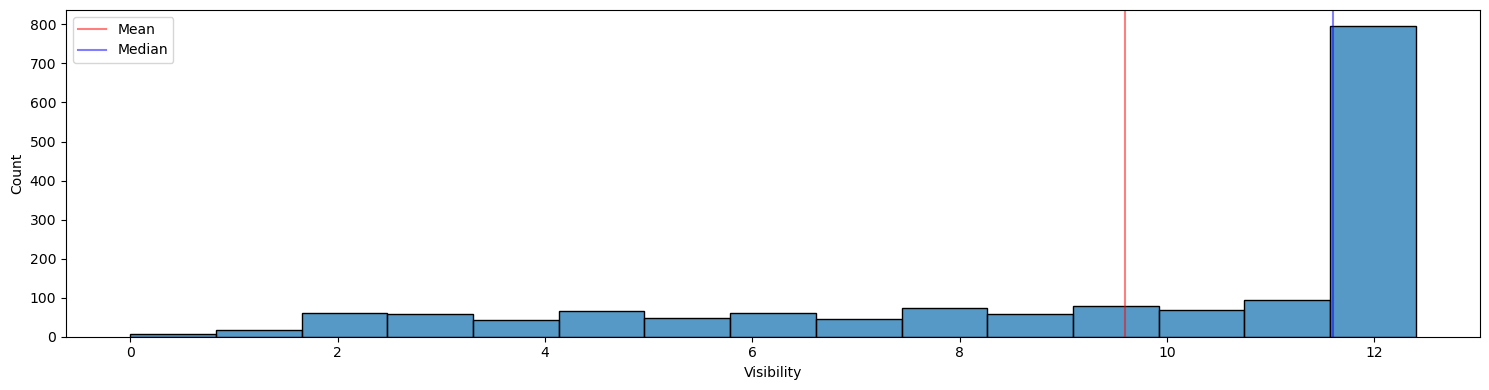

In [12]:
# analyzing the first feature to be imputed
histplot(feature = "Visibility") # user defined function

After initially examining the visibility data, it is evident that the median is more appropriate for replacing missing values. In the majority of observations, visibility is possible up to 12 miles. The mean, at approximately 9.5, is not suitable for imputation. The distribution of visibility data is skewed, making the median a more reliable measure. Using the median for missing data imputation will likely yield more accurate and representative visibility estimates.

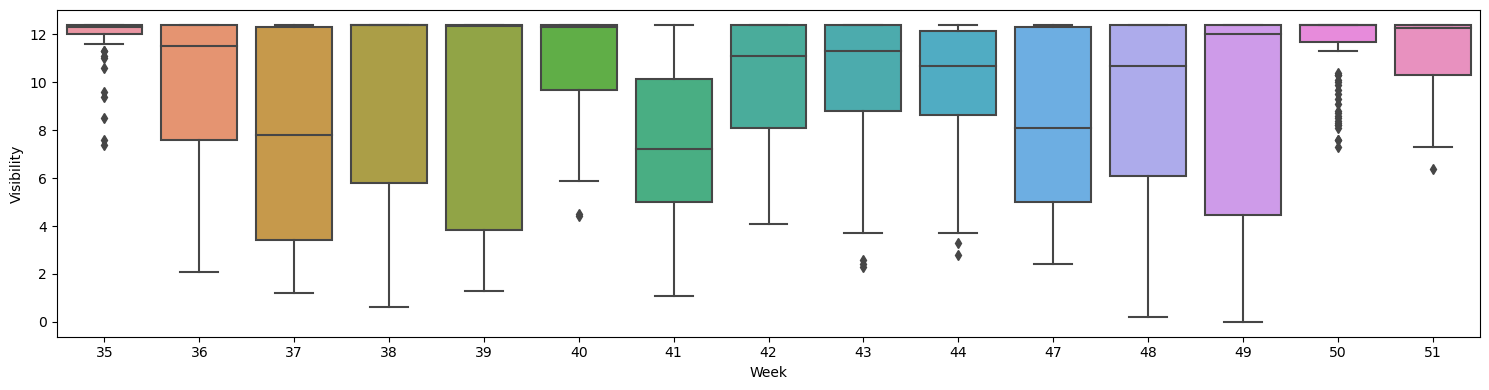

In [13]:
boxplot(feature = "Week", feature_2 = "Visibility") # user defined function

Above, the relationship between calendar week and visibility is under consideration. Most weeks have very clear visibility conditions. However, visibility is significantly worse in some weeks. This leads to the conclusion that the median visibility per calendar week is a better imputation method than simply using the overall median visibility. As a best practice, the median rather than the mean is utilized.

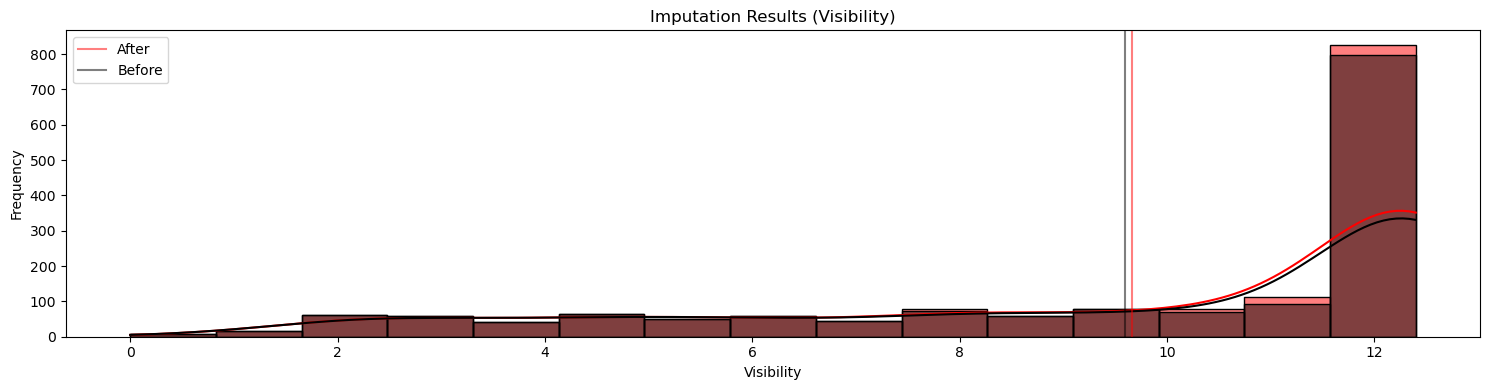

In [14]:
# calculating the median visibility for each week
median_visibility_by_week = df.groupby("Week")["Visibility"].transform("median")

# imputing missing values in the "Visibility" column
df["Visibility"] = df["Visibility"].fillna(median_visibility_by_week)

imputation_check(feature = "Visibility") # plotting old values above new ones

The graphic displays the distribution of visibility observations before and after imputation. It reveals that most missing values were imputed with visibility of ~ 12 miles, as expected. One can also see that some observations were imputed with shorter visibility distances. Despite these imputations, the fundamental distribution of the data remained essentially unchanged. This observation concludes that the imputation was successful and appropriate, demonstrating its effectiveness in preserving the overall data integrity without significantly altering its distribution.

<h4>Dew Point Temperature</h4><br>

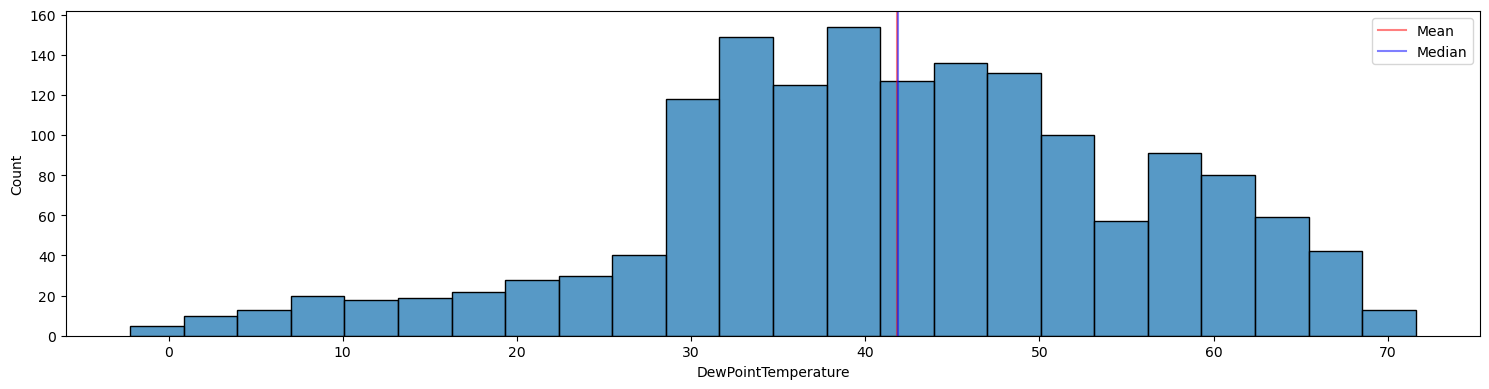

In [15]:
histplot(feature = "DewPointTemperature") # user defined function

The dew point temperatures in Chicago vary significantly. They range from highs up to 70°F to lows of 0°F from September to December 2023. Observations over time show a relatively normal distribution, as indicated by the mean and median being very close to each other. However, the observations are slightly left-skewed. Given the substantial variability, imputing the Dew Point Temperature using the median would not be optimal. Luckily, the DewPointTemperature can be calculated with the Magnus formula ([see here](https://calculator.academy/fog-equation-calculator/#:~:text=Fog%20Equation%20(Dew%20Point%20Formula)&text=α%20is%20a%20function%20of,for%20the%20Magnus%2DTetens%20approximation)).

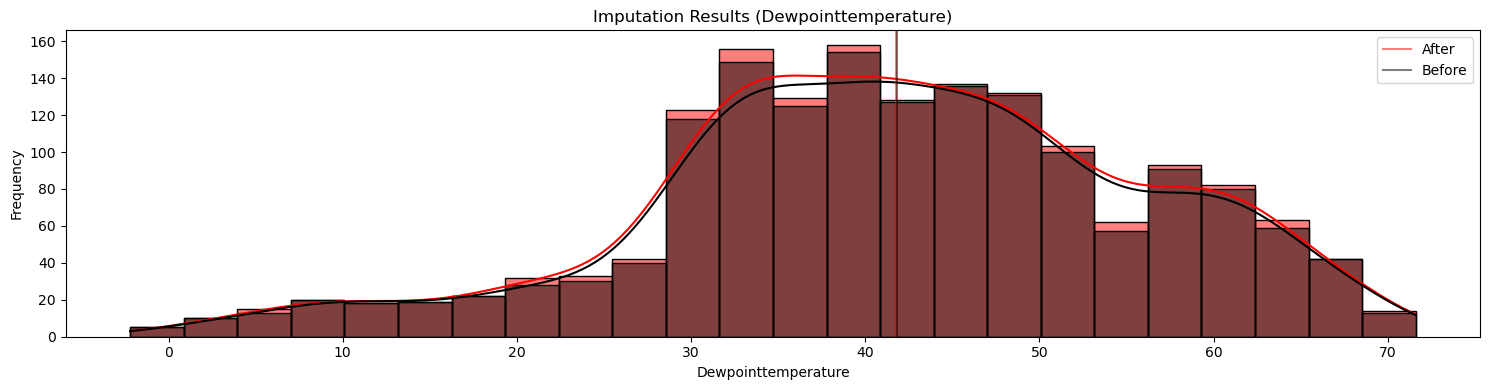

In [16]:
# converting temperature from Fahrenheit to Celsius
df["TemperatureC"] = (df["Temperature"] - 32) * (5/9)

# constants for the Magnus formula
a = 17.27
b = 237.7

# calculating the intermediate value of the formula
alpha = lambda T, RH: (a * T / (b + T)) + np.log(RH / 100)

# calculating Dew Point in Celsius
DewPointCelsius = (b * df.apply(lambda row: alpha(row["TemperatureC"],
                                                  row["Humidity"]),
                                axis=1))/\
                  (a - df.apply(lambda row: alpha(row["TemperatureC"],
                                                  row["Humidity"]),
                                axis=1))

# converting Dew Point from Celsius back to Fahrenheit
DewPointFahrenheit = ((DewPointCelsius * (9/5)) + 32).round(decimals = 1)

# dropping the calculation column
df.drop('TemperatureC', axis=1, inplace=True)

# imputing missing values in the "DewPointTemperature" column
df["DewPointTemperature"] = df["DewPointTemperature"].fillna(DewPointFahrenheit)

imputation_check(feature = "DewPointTemperature") # plotting old values above new ones

The graphic illustrates the dew point temperature observations' distribution before and after imputation. Missing values were filled in a manner consistent with the original data pattern according to the Magnus formula. The preservation of the essential characteristics of the distribution confirms the imputation's success. This approach maintained the overall integrity of the dataset, ensuring that the imputation process did not significantly skew its distribution. Therefore, the strategy used for imputing missing values is deemed both successful and appropriate for the context.

<h4>SolarRadiation</h4><br>

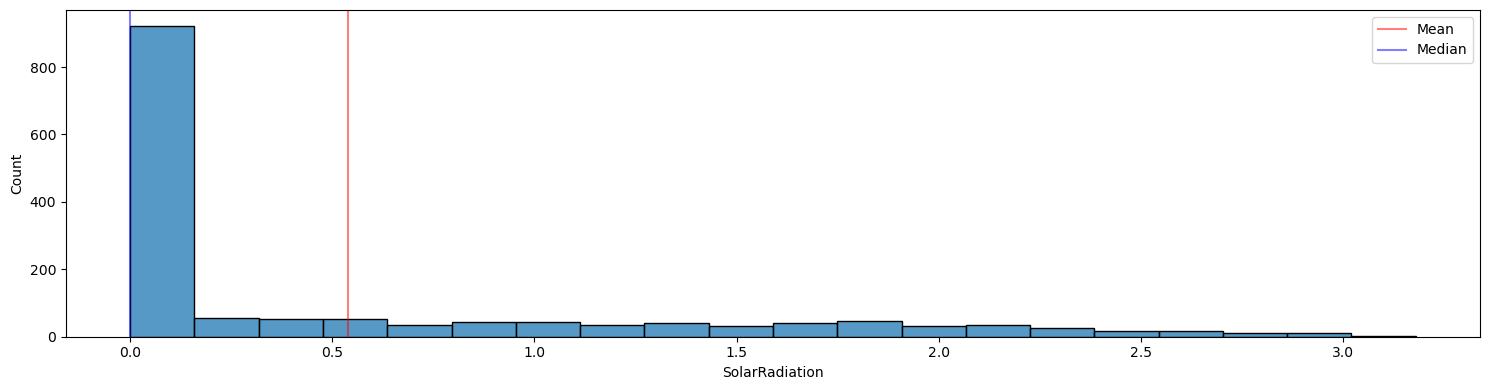

In [17]:
histplot("SolarRadiation") # user defined function

On many days, there is absolutely no solar radiation. Accordingly, Chicago has experienced poor weather on numerous occasions at the end of 2023. The distribution of this phenomenon is heavily skewed to the right, indicating that days with no solar radiation are not rare but rather a significant pattern. Both imputation methods appear unsatisfactory, using the mean (approximately 0.5) and the median (0). The data's skewed distribution challenges conventional imputation techniques, highlighting the need for more sophisticated methods to accurately capture Chicago's solar radiation patterns.

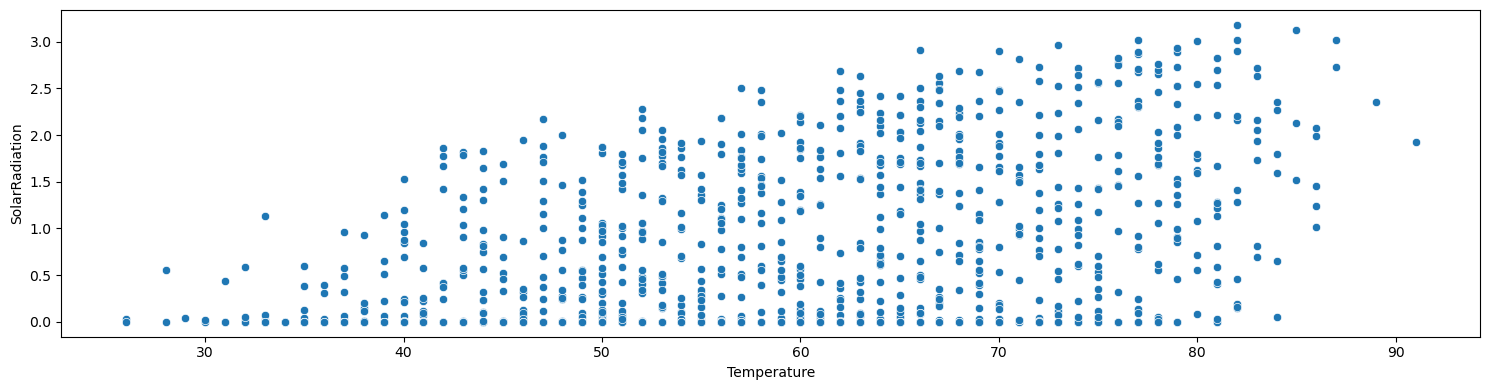

In [18]:
scatterplot(feature = "Temperature", feature_2 = "SolarRadiation") # user defined function

As expected, temperature correlates with solar radiation. However, observations show that values of zero solar radiation can occur even at temperatures as low as 80°F. This suggests that a simple linear regression to estimate missing solar radiation values based on temperature is inadequate. Consequently, due to the frequent observation of days with zero solar radiation, a decision rule is used for imputation: If the temperature is below 80°F, a solar radiation value of zero is assumed; if it is above, the average solar radiation value is used. This rule reflects an attempt to better account for the complex relationship between temperature and solar radiation when imputing missing data.

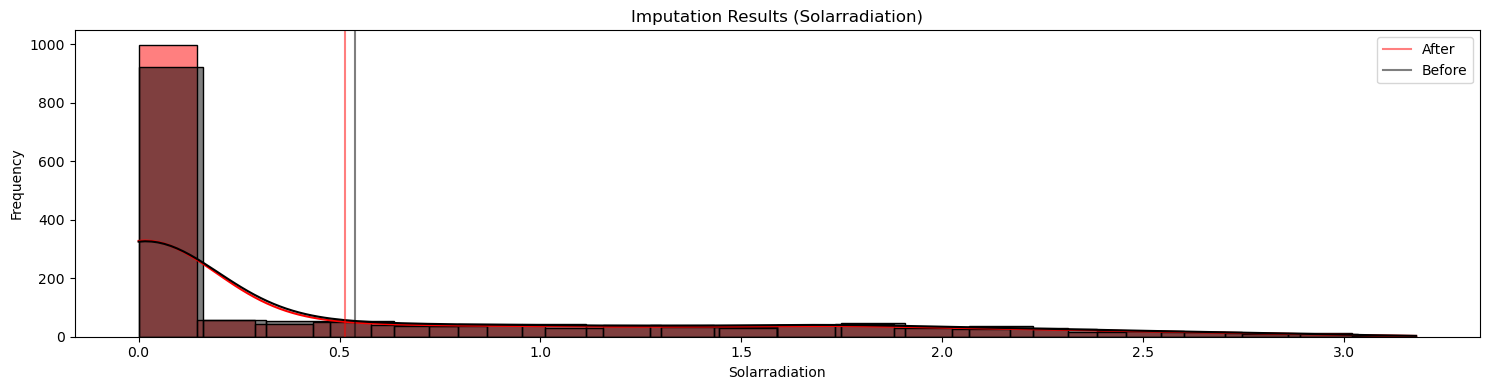

In [19]:
# calculating mean solar radiation
mean_SolarRadiation = df['SolarRadiation'].mean()

def impute_solar_radiation(row):
    # Check if SolarRadiation is NaN
    if pd.isnull(row['SolarRadiation']):
        if row['Temperature'] < 80:
            return 0
        else: # imputing with the mean
            return mean_SolarRadiation
    else: # returning value for imputation
        return row['SolarRadiation']

# imputing missing values in the "SolarRadiation" column
df['SolarRadiation'] = df.apply(impute_solar_radiation, axis=1)

imputation_check(feature = "SolarRadiation") # plotting old values above new ones

The figure above illustrates the distribution of solar radiation before and after imputation. Most of the observations were imputed with a value of 0. Values above 80°F were imputed with the prior mean. Overall, the mean after imputation slightly shifted to the left, but it remains very close to the original mean. While the imputation is not ideal, it is acceptable given that only about 5% of the solar radiation data was missing.

In [20]:
print(f"Are there any missing values remaining in the dataset? \t\
{'Yes.' if df.isna().any().any() else 'No.'}")

Are there any missing values remaining in the dataset? 	No.


<h3>Transforming Text Features</h3><br>

In [21]:
# converting "Holiday" column to boolean
df["Holiday"] = df["Holiday"].map({"Yes": 1, "No": 0})

# converting "FunctioningDay" column to boolean
df["FunctioningDay"] = df["FunctioningDay"].map({"Yes": 1, "No": 0})

The two features, Holiday and Functioning Day, must be transformed into numerical features so that models can subsequently utilize them. In this transformation, the presence of the feature is denoted by '1', while its absence is indicated by '0'.

<h3>Further Feature Engineering</h3><br>

In [22]:
df["d_Snow"] = np.where(df["Snowfall"] > 0, 1, 0) # 1 it snowed 0 it did not
df["d_Rain"] = np.where(df["Rainfall"] > 0, 1, 0) # 1 it rained 0 it did not

The code above converts snowfall and rainfall amounts into binary indicators, simplifying weather data analysis. A value of '1' indicates snow or rain occurred, while '0' denotes no precipitation. This binary categorization enhances data clarity, making identifying days with specific weather events straightforward. It allows for an efficient way to track the presence of rain or snow, facilitating quicker insights into weather patterns.

In [23]:
# coding weekend, weekday values 5 & 6 are equivalent to Saturday & Sunday
df["d_Weekend"] = df["Weekday"].apply(lambda x: 1 if x >= 5 else 0)

By categorizing days into weekends and weekdays, the d_Weekend feature recognizes the typical shift in human behavior patterns, where weekends (Saturday and Sunday, encoded as 5 and 6) often involve different activities and schedules than weekdays. This binary indicator simplifies the analysis of day-of-week effects.

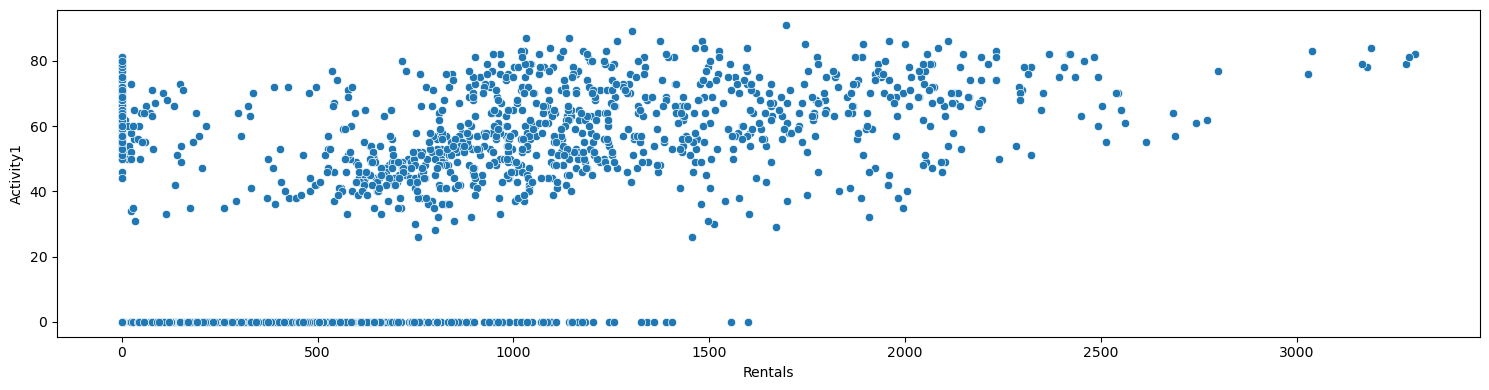

In [24]:
# coding awake time of an average citizen, assuming he gets up at 7am
# and sleeps in by 11pm.
df["d_Awake"] = np.where(((df["Hour"] >= 7) & (df["Hour"] <= 22)), 1, 0)

# connecting awake state with temperature to create activity level
df["Activity1"] = df["d_Awake"] * df["Temperature"]
df["Activity2"] = df["d_Awake"] * df["DewPointTemperature"]

# plotting newly engineered feature Activity1 to Rentals
scatterplot(feature = "Rentals", feature_2 = "Activity1")

The d_Awake feature models a general daily awake period from 7 am to 11 pm, assuming this timeframe encapsulates most human activity. Converting the hours of the day into a binary awake/asleep state allows for examining data within the context of human active hours, potentially filtering out noise from less relevant periods. Combining the awake state with (dew point) temperature through the activity feature offers a nuanced view of how weather conditions might influence human behavior. Specifically, this interaction suggests that temperature could vary in activity levels depending on whether people are generally awake and likely to be outdoors or indoors. High temperatures during awake periods correlate with increased outdoor activities in some contexts or, conversely, decreased activity if the heat discourages outdoor pursuits, as evident in the scatterplot above. This engineered feature is not perfect, but one can identify a correlation between the usual daily activity levels of the average Chicago citizen and the number of rentals.

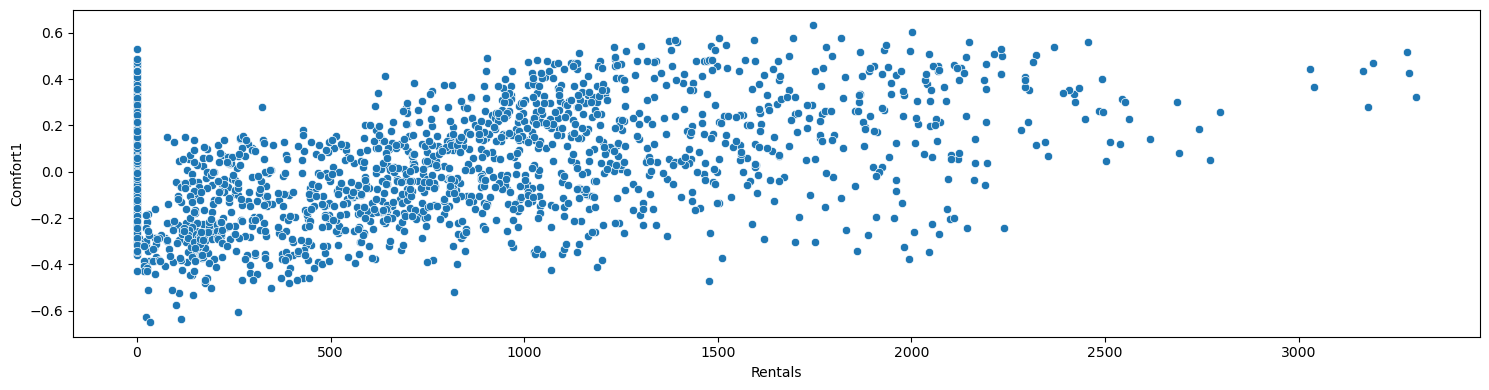

In [25]:
# calculating a comfort level to drive a bike
df["Comfort1"] = df["Temperature"]/df["Temperature"].max() - \
    df["Humidity"]/df["Humidity"].max()

df["Comfort2"] = df["DewPointTemperature"]/df["DewPointTemperature"].max() - \
    df["Humidity"]/df["Humidity"].max()

# plotting newly engineered feature Comfort1 to Rentals
scatterplot(feature = "Rentals", feature_2 = "Comfort1")

Two critical environmental factors affecting outdoor activities, (dew point) temperature, and humidity, are combined to gauge the comfort level of driving a bike. By normalizing both (dew point) temperature and humidity against their respective maximum values in the dataset, this calculation puts them on a comparable scale, ranging from '0' to '1'. The feature subtracts the normalized humidity from the normalized temperature, intuitively capturing the idea that higher temperatures and lower humidity levels typically correspond to more comfortable conditions for biking. Conversely, even with moderate temperatures, high humidity levels can reduce comfort due to the muggy feeling that makes physical exertion less pleasant. This feature offers a simple yet insightful way to assess biking conditions, potentially aiding in decision-making for planning outdoor activities or analyzing biking trends. As indicated above, the comfort level correlates with the number of rentals. Days without rentals could pose a problem as they significantly distort the distribution. This issue will be addressed in further detail later.

In [26]:
df.head(n = 5) # getting an overview of current features

,DateHour,Temperature,Humidity,WindSpeed,Visibility,DewPointTemperature,Rainfall,Snowfall,SolarRadiation,Holiday,FunctioningDay,Rentals,m_Visibility,m_DewPointTemperature,m_SolarRadiation,Month,Week,Day,Weekday,Hour,Minute,Second,Night,Morning,Afternoon,Evening,d_Snow,d_Rain,d_Weekend,d_Awake,Activity1,Activity2,Comfort1,Comfort2
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
mb_1039,2023-10-14 05:59:54.810,52,81,0.4,2.9,46.4,0.0,0.0,0.00,0,1,519,0,0,0,10,41,14,5,5,59,54,1,0,0,0,0,0,1,0,0,0.0,-0.263623,-0.187007
mb_1330,2023-10-26 08:59:53.355,51,53,2.2,11.3,35.2,0.0,0.0,1.01,0,1,1251,1,0,0,10,43,26,3,8,59,53,0,1,0,0,0,0,0,1,51,35.2,0.014048,-0.054772
mb_551,2023-09-23 21:59:57.250,56,49,2.5,3.4,38.8,0.0,0.0,0.00,0,1,1685,0,0,0,9,38,23,5,21,59,57,0,0,0,1,0,0,1,1,56,38.8,0.110230,0.036745
mb_2103,2023-12-19 14:00:00.000,69,32,9.8,12.4,38.7,0.0,0.0,2.36,0,0,0,0,0,0,12,51,19,1,14,0,0,0,0,1,0,0,0,0,1,69,38.7,0.428345,0.210606
mb_1430,2023-10-30 12:59:52.855,53,20,2.9,10.8,12.9,0.0,0.0,1.96,0,1,814,0,0,0,10,44,30,0,12,59,52,0,0,1,0,0,0,0,1,53,12.9,0.376232,-0.026018


<h3>Data Transformation</h3><br>

In [27]:
# relevant feature list
features = df.select_dtypes(include=[np.number]).columns

# pre-filter features to ensure they are suitable for log transformation
features_filtered = [
    feature for feature in features if df[feature].min() >= 0 \
    and len(df[feature].unique()) > 2]

# calculating skewness before transformation for filtered features
skewness_original = df[features_filtered].skew().round(decimals = 2)

# applying log transformation to each selected feature
for feature in features_filtered:
    df[f"log_{feature}"] = np.log1p(df[feature])

# calculating skewness after transformation
features_transformed = [f"log_{feature}" for feature in features_filtered]
skewness_transformed = df[features_transformed].skew().round(decimals = 2)

# Combine both skewness values into a DataFrame for comparison
skewness_comparison = pd.DataFrame({
    "Feature": features_filtered,
    "Original_Skewness": skewness_original.values,
    "Transformed_Skewness": skewness_transformed.values,
    "Difference": abs(abs(skewness_transformed.values)\
    - abs(skewness_original.values))})

# showing the comparison
skewness_comparison.sort_values(by = "Difference", ascending = False)

# inverse for a logarithm = np.expm1()

,Feature,Original_Skewness,Transformed_Skewness,Difference
12,Hour,-0.01,-1.18,1.17
7,Rentals,0.72,-1.83,1.11
4,Rainfall,11.63,10.54,1.09
10,Day,-0.01,-0.99,0.98
11,Weekday,-0.04,-0.78,0.74
2,WindSpeed,1.05,-0.32,0.73
1,Humidity,0.02,-0.69,0.67
3,Visibility,-1.03,-1.66,0.63
5,Snowfall,12.38,11.87,0.51
6,SolarRadiation,1.43,1.07,0.36


The data transformation decreased the skewness of only a few features (Rainfall, WindSpeed, Snowfall, SolarRadiation, Week, and Month), which saw adjustments towards a slightly more normalized distribution, indicating the effectiveness of the transformations in reducing skewness across features with diverse characteristics. However, within all other features, this transformation increased skewness. Later, it will be evident if these transformations were relevant for modeling.

<h3>Correlations with Rentals</h3><br>

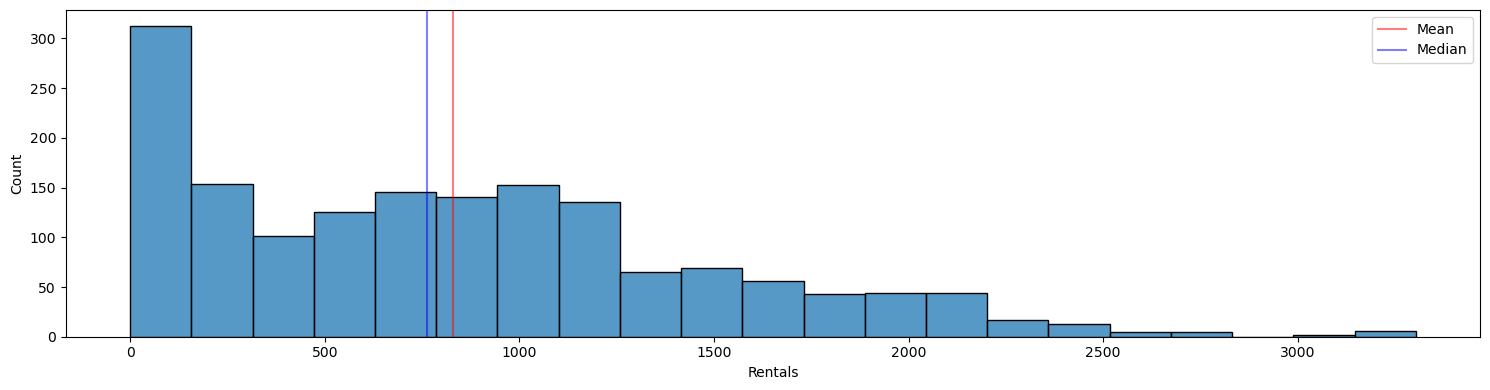

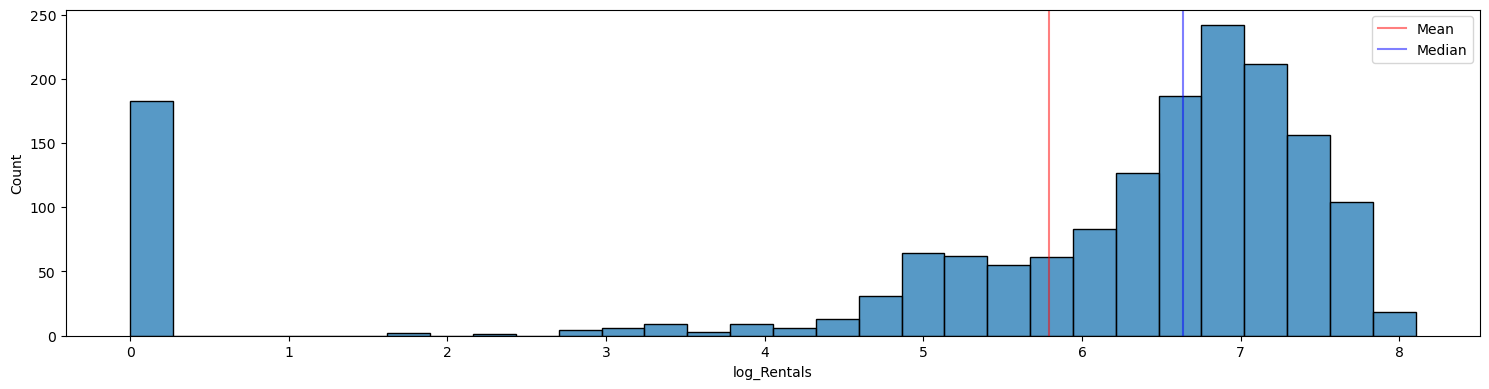

In [28]:
# visualizing dependent feature
histplot("Rentals")     # user defined funciton
histplot("log_Rentals") # user defined funciton

The analysis of the original distribution of rentals reveals a right-skewed distribution. This observation is further substantiated by the proximity of the mean and median values, indicating a relatively symmetrical distribution despite the rightward skew. When applying a logarithmic transformation to the rental data, the distribution shows an increased skewness. This transformation delineates a more pronounced separation between instances of zero rentals and the substantial segment exhibiting rental activity. Such a transformed distribution may offer improved utility for analytical modeling purposes. Specifically, it facilitates a more distinct categorization of rental occurrences, enabling a more accurate prediction of rental behaviors. In this context, it is plausible to anticipate a strong correlation between the variable FunctioningDay and the logarithmically transformed rental variable (log_Rentals). Consequently, the log-transformed rental distribution may provide a more reliable basis for identifying and analyzing patterns related to the operational status of the rental service, thus enhancing the predictive accuracy of models.

In [29]:
# analyzing (Pearson) correlations
corr = df.select_dtypes(include=[np.number]).corr(method = "pearson").round(2)
corr = corr.loc[ :,["Rentals", "log_Rentals"] ].sort_values(
    by = "log_Rentals", ascending = False)

# filtering to keep correlations with log_Rentals higher/ lower than 0.15/-0.15
corr_f = corr[(corr["log_Rentals"] > 0.15) | (corr["log_Rentals"] < -0.15)]

# Display the filtered correlations
corr_f

,Rentals,log_Rentals
log_Rentals,0.72,1.00
FunctioningDay,0.45,0.92
Rentals,1.00,0.72
Comfort1,0.49,0.19
log_Activity1,0.50,0.19
d_Awake,0.49,0.19
Activity1,0.53,0.17
Hour,0.42,0.17
log_Hour,0.42,0.16
log_Rainfall,-0.15,-0.16


As anticipated, the correlation between FunctioningDay and Rentals is remarkably strong. When the business does not operate, it logically follows that no rentals are generated. This observation reveals another issue: the log_rentals exhibit a relatively weak correlation with the other features. Accordingly, this showcases the critical importance of accounting for the effect of Functioning Day in advance to ensure that days with high activity levels or favorable comfort conditions do not misleadingly predict high rental volumes when the business is not operating. Besides the operating status of the business, the biker's comfort and activity level, the time of day, rain conditions, and humidity strongly influence rentals. It is surprising to note that factors such as weekends, temperature in isolation, wind, visibility, snow, and solar radiation have an insignificantly small impact on rentals.

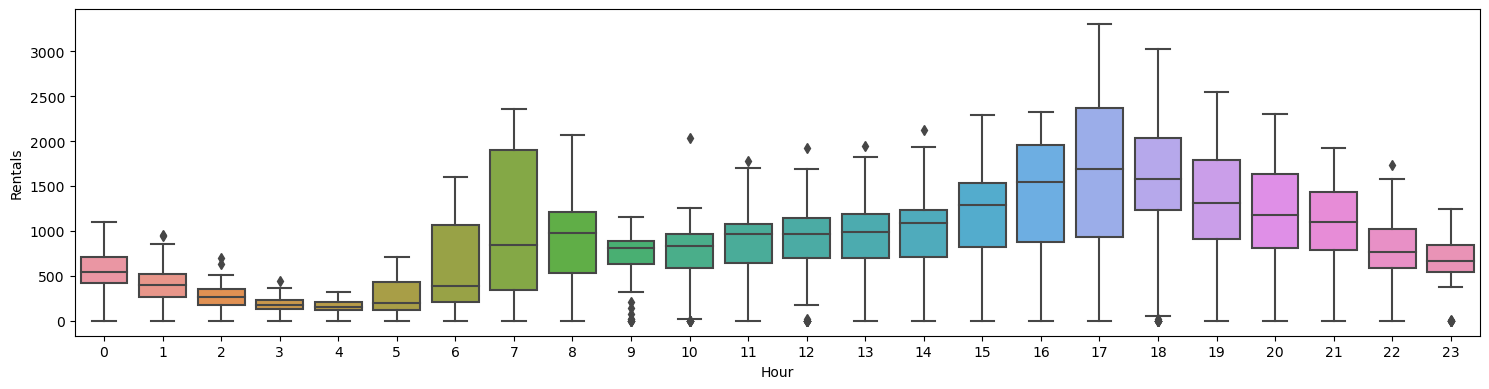

In [30]:
boxplot("Hour", "Rentals") # user defined function

It is evident that there is an increased incidence of bicycle rentals during peak hours. A significant number of bicycles are borrowed between 6 to 8 AM. Similarly, there is a substantial uptick in bicycle rentals starting from 3 PM onwards, with the demand peaking during the evening. This pattern can be attributed to the fact that most individuals have leisure time during these periods. Conversely, from midnight to 6 AM, there is a noticeable decline in bicycle rentals, which is understandable considering the time of day.

<h3>Reengineering all Features</h3><br>
Hence, all features are reevaluated by multiplying them with FunctioningDay. This approach ensures that, on non-operational days, features automatically have no impact, thereby more accurately discerning the effect of each feature on days when operations occur.

In [31]:
# x-data
# dropping dependent variables and non numeric features
x = list(df.drop(labels = ["DateHour", "Rentals", "log_Rentals"], axis = 1))

# dropping FunctioningDay after multiplying each feature with it
df_x = df[x].multiply(df["FunctioningDay"],
                      axis = 0)#.drop(labels = ["FunctioningDay"], axis = 1)

# y-data
df_y = df["log_Rentals"]

# merging the data together for statsmodels exploration
df_adj = pd.concat([df_x, df_y], axis = 1)

# observing descriptive statistics of all data
df_adj.describe().round(2)

,Temperature,Humidity,WindSpeed,Visibility,DewPointTemperature,Rainfall,Snowfall,SolarRadiation,Holiday,FunctioningDay,m_Visibility,m_DewPointTemperature,m_SolarRadiation,Month,Week,Day,Weekday,Hour,Minute,Second,Night,Morning,Afternoon,Evening,d_Snow,d_Rain,d_Weekend,d_Awake,Activity1,Activity2,Comfort1,Comfort2,log_Temperature,log_Humidity,log_WindSpeed,log_Visibility,log_Rainfall,log_Snowfall,log_SolarRadiation,log_Month,log_Week,log_Day,log_Weekday,log_Hour,log_Second,log_Activity1,log_Rentals
count,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.0,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00,1638.00
mean,50.45,52.19,2.97,8.57,36.51,0.00,0.00,0.45,0.04,0.89,0.03,0.03,0.04,9.15,38.03,13.73,2.8,10.23,34.04,32.17,0.23,0.21,0.22,0.23,0.01,0.04,0.26,0.59,34.67,23.85,0.02,-0.03,3.58,3.58,1.21,2.03,0.00,0.00,0.27,2.15,3.35,2.30,1.12,2.03,2.33,2.38,5.79
std,21.82,25.70,2.20,4.49,18.88,0.03,0.02,0.77,0.20,0.32,0.17,0.17,0.20,3.42,14.29,9.72,2.1,7.51,29.16,27.60,0.42,0.41,0.42,0.42,0.11,0.18,0.44,0.49,30.91,23.05,0.24,0.18,1.29,1.31,0.63,0.84,0.03,0.02,0.42,0.77,1.19,1.07,0.71,1.06,2.00,2.01,2.24
min,0.00,0.00,0.00,0.00,-2.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.20,-0.65,-0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,43.00,38.00,1.30,4.90,28.95,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,9.00,37.00,5.00,1.0,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.15,-0.16,3.78,3.66,0.83,1.77,0.00,0.00,0.00,2.30,3.64,1.79,0.69,1.39,0.00,0.00,5.49
50%,53.00,55.00,2.70,11.00,38.60,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,10.00,41.00,14.00,3.0,10.00,59.00,53.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,44.00,27.30,0.00,0.00,3.99,4.03,1.31,2.48,0.00,0.00,0.00,2.40,3.74,2.71,1.39,2.40,3.99,3.81,6.64
75%,66.00,72.00,4.30,12.40,49.60,0.00,0.00,0.65,0.00,1.00,0.00,0.00,0.00,11.00,48.00,22.00,5.0,17.00,59.00,56.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,62.75,43.15,0.17,0.09,4.20,4.29,1.67,2.60,0.00,0.00,0.50,2.48,3.89,3.14,1.79,2.89,4.04,4.15,7.09
max,91.00,97.00,12.80,12.40,71.60,0.51,0.30,3.18,1.00,1.00,1.00,1.00,1.00,12.00,51.00,31.00,6.0,23.00,59.00,59.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,91.00,71.60,0.64,0.42,4.52,4.58,2.62,2.60,0.41,0.26,1.43,2.56,3.95,3.47,1.95,3.18,4.09,4.52,8.10


Based on the summary statistics, it is evident that all features now possess zero values, which will facilitate the modeling process. This simplification arises after normalizing the status of the closed business status to zero for all features.

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<h2>Modeling</h2>
<h3>Full, Fit, & Base Model</h3><br>
Before proceeding with candidate modeling, a thorough examination of the full base and fit model is conducted. This step is crucial for ensuring that the foundational aspects and compatibility of the models are fully understood and assessed, laying the groundwork for a more informed and effective candidate modeling process.

In [32]:
# looping for an easier statsmodels input
for feature in df_adj:
    print(f"""{feature} + """, end = "")

Temperature + Humidity + WindSpeed + Visibility + DewPointTemperature + Rainfall + Snowfall + SolarRadiation + Holiday + FunctioningDay + m_Visibility + m_DewPointTemperature + m_SolarRadiation + Month + Week + Day + Weekday + Hour + Minute + Second + Night + Morning + Afternoon + Evening + d_Snow + d_Rain + d_Weekend + d_Awake + Activity1 + Activity2 + Comfort1 + Comfort2 + log_Temperature + log_Humidity + log_WindSpeed + log_Visibility + log_Rainfall + log_Snowfall + log_SolarRadiation + log_Month + log_Week + log_Day + log_Weekday + log_Hour + log_Second + log_Activity1 + log_Rentals + 

In [33]:
# instantiating a full model
lm = smf.ols(formula = """log_Rentals ~ Temperature + Humidity + WindSpeed
+ Visibility + DewPointTemperature + Rainfall + Snowfall + SolarRadiation
+ Holiday + FunctioningDay + m_Visibility + m_DewPointTemperature
+ m_SolarRadiation + Month + Week + Day + Weekday + Hour + Minute + Second
+ Night + Morning + Afternoon + Evening + d_Snow + d_Rain + d_Weekend
+ d_Awake + Activity1 + Activity2 + Comfort1 + Comfort2 + log_Temperature
+ log_Humidity + log_WindSpeed + log_Visibility + log_Rainfall
+ log_Snowfall + log_SolarRadiation + log_Month + log_Week + log_Day
+ log_Weekday + log_Hour + log_Second + log_Activity1""", data = df_adj)

full_model = lm.fit()       # fitting the data
print(full_model.summary()) # printing results

                            OLS Regression Results                            
Dep. Variable:            log_Rentals   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     847.5
Date:                Thu, 22 Feb 2024   Prob (F-statistic):               0.00
Time:                        19:38:20   Log-Likelihood:                -1047.2
No. Observations:                1638   AIC:                             2182.
Df Residuals:                    1594   BIC:                             2420.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.748e-

High multicollinearity exists when all features are considered, which can be attributed to the fact that all variables were interconnected with FunctioningDay.

In [34]:
# instantiating a base fit model
lm = smf.ols(formula = """log_Rentals ~ Temperature + Humidity
+ DewPointTemperature + Rainfall + SolarRadiation
+ Holiday + FunctioningDay""", data = df_adj)

base_model = lm.fit()       # fitting the data
print(base_model.summary()) # printing results

                            OLS Regression Results                            
Dep. Variable:            log_Rentals   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     2422.
Date:                Thu, 22 Feb 2024   Prob (F-statistic):               0.00
Time:                        19:38:20   Log-Likelihood:                -1652.2
No. Observations:                1638   AIC:                             3320.
Df Residuals:                    1630   BIC:                             3364.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.423e-14    

Reverting to the base model does not appear to be a prudent choice, especially given that, according to the p-values, all features possess statistical explanatory value. Consequently, a tailored model should, in theory, exhibit superior performance.

In [35]:
# instantiating a fit model
lm = smf.ols(formula = """log_Rentals ~ Temperature + Humidity 
+ DewPointTemperature + Rainfall + Snowfall 
+ Holiday + m_Visibility 
+ Week + Day + Weekday + Hour 
+ Morning + Afternoon + Evening + d_Snow + d_Rain 
+ Activity1 + Activity2 + Comfort1 + Comfort2 
+ log_Humidity + log_WindSpeed + log_Rainfall
+ log_Snowfall + log_SolarRadiation + log_Month + log_Week 
+ log_Hour""", data = df_adj)

fit_model = lm.fit()       # fitting the data
print(fit_model.summary()) # printing results

                            OLS Regression Results                            
Dep. Variable:            log_Rentals   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     1401.
Date:                Thu, 22 Feb 2024   Prob (F-statistic):               0.00
Time:                        19:38:21   Log-Likelihood:                -1055.9
No. Observations:                1638   AIC:                             2166.
Df Residuals:                    1611   BIC:                             2312.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -4.912e-05    

By iteratively removing features based on the highest p-values until a significance level of 5% was achieved, including variables such as Night, FunctioningDay, WindSpeed, Visibility, log_Visibility, SolarRadiation, log_Temperature, d_Awake, log_Activity1, Second, log_Day, m_SolarRadiation, Minute, log_Second, Month, m_DewPointTemperature, d_Weekend, and log_Weekday, a model with an equivalent R-squared value while simultaneously achieving lower AIC and BIC scores is attained, which suggests that the remaining features in the fitted model will likely perform optimally within the candidate models, indicating a streamlined and potentially more accurate predictive framework.

In [36]:
# creating a dataframe with all fit x features
df_x_fit = df_x[["Temperature", "Humidity", "DewPointTemperature", "Rainfall",
                "Snowfall", "Holiday", "m_Visibility", "Week", "Day",
                "Weekday", "Hour", "Morning", "Afternoon", "Evening",
                "d_Snow", "d_Rain", "Activity1", "Activity2", "Comfort1",
                "Comfort2", "log_Humidity", "log_WindSpeed", "log_Rainfall",
                "log_Snowfall", "log_SolarRadiation", "log_Month", "log_Week", 
                "log_Hour"]]

<h3>Defining Functions</h3><br>
Several functions are defined at this juncture to minimize the coding effort required for generating graphical outputs, developing candidate models, and hypertuning those models.

In [37]:
# creating a modeling function
def model(x, y, model, name, scaling = False, coeff = 0, residuals = 0, tree = 0, feature_importance = 0):
    """
    x = dependent variables
    y = independent variable
    model = regression model to use
    name = regression model name
    coeff = when True then printing coefficients
    residuals = when True plotting residual errors
    tree = when True plotting tree
    feature_importance = when True plotting importance of features
    """
    # train-test split
    x_train, x_test, y_train, y_test = train_test_split(x,
                                                        y,
                                                        test_size    = 0.25,
                                                        random_state = 1836)
    if scaling:
        scaler = StandardScaler()           # instantiating a StandardScaler() object
        scaler.fit(x_train)                 # fitting scaler to data
        x_train = scaler.transform(x_train) # transforming data after fit
        x_test = scaler.transform(x_test)   # transforming data after fit

    model_fit = model.fit(x_train, y_train) # fitting training data
    model_pred = model.predict(x_test)      # predicting new data

    # scoring results
    model_train_score = model.score(x_train, y_train).round(4) # using R-square
    model_test_score  = model.score(x_test, y_test).round(4)   # using R-square
    model_gap         = abs(model_train_score - model_test_score).round(4)
    
    # dynamically printing model summary
    print(f"""\
Model Name:     {name}
Train_Score:    {model_train_score}
Test_Score:     {model_test_score}
Train-Test Gap: {model_gap}""")
    if coeff: # breaks if you try to use K-Neighbors/Tree with coeff = True
        # zipping each feature name to its coefficient
        model_coefficients = zip(x.columns, model.coef_.round(decimals = 4))
        
        # setting up a placeholder list to store model features
        coefficient_lst = [("intercept", model.intercept_.round(decimals = 4))]
        
        # printing out each feature-coefficient pair one by one
        for coefficient in model_coefficients:
            coefficient_lst.append(coefficient)
        
        print(f"""\nCoefficents
---------------------------------------
{pd.DataFrame(data = coefficient_lst, columns = ["Feature", "Coefficient"])}""")
    
    if residuals == 1: # printing residuals when condition is met
        model_pred = model.predict(x_test) # applying model to validation set
        model_residuals = {"True"      : y_test,
                           "Predicted" : model_pred} # organizing residuals
        
        resid_df = pd.DataFrame(data = model_residuals) # converting residuals into df
        
        # setting figure size
        fig, ax = plt.subplots(figsize = (15, 6)) 
        
        # developing a residual plot
        sns.residplot(data        = resid_df,
                      x           = 'Predicted',
                      y           = 'True',
                      lowess      = True,
                      color       = 'blue',
                      scatter_kws = {'alpha': 0.3},   # data point transparency
                      line_kws    = {'color': 'red'}) # line color
        
        # title and axis labels
        plt.title(label   = f"Residual Plot - {name} Model")
        plt.xlabel(xlabel = "Predicted Rentals")
        plt.ylabel(ylabel = "Actual Rentals")
        
        # layout and rendering visual
        plt.tight_layout()
        plt.show()
        
    if tree == 1: # printing tree
        # setting figure size
        plt.figure(figsize = (50, 6)) # adjusting to better fit the visual
        
        # developing a plotted tree
        plot_tree(decision_tree = model, # changing to pruned_tree_fit
          feature_names = list(x.columns),
          filled        = True, 
          rounded       = True, 
          fontsize      = 14)
        
        # rendering the plot
        plt.tight_layout()
        plt.show()

    if feature_importance == 1:
        # declaring the number
        n_features = x.shape[1]
        
        # setting plot window
        fig, ax = plt.subplots(figsize=(12,9))
        
        # plotting a feature importance visual
        plt.barh(range(n_features), model.feature_importances_, align = "center")
        plt.yticks(np.arange(n_features), x.columns)
        plt.xlabel("Feature importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
        
def tuning_results(cv_results, n = 5):
    """
This function will display the top "n" models from hyperparameter tuning,
based on "rank_test_score".

PARAMETERS
----------
cv_results = results dictionary from the attribute ".cv_results_"
n          = number of models to display
    """
    param_lst = [] # setting a parameter list

    for result in cv_results["params"]: # iterating over each parameter
        result = str(result).replace(":", "=")
        param_lst.append(result[1:-1]) # saving each parameter
        
    results_df = pd.DataFrame(data = {
        "Model_Rank" : cv_results["rank_test_score"],
        "Mean_Test_Score" : cv_results["mean_test_score"],
        "SD_Test_Score" : cv_results["std_test_score"],
        "Parameters" : param_lst # returning the model results
    })

    # sorting the best models and returning the best model
    results_df = results_df.sort_values(by = "Model_Rank", axis = 0)
    return results_df.head(n = n)

# Creating a Hyperparameter Tuning Function
def hyperparamter_tuning(x, y, model, name, parameters, n = 5, scaling = False):
    """
    x = independent features
    y = dependent feature
    model = model to be used
    name = model name to ease identification
    parameters = parameter grid
    n = number of modeling outputs
    scaling = scaling the data
    
    """
    # RandomizedSearchCV objects
    tuned_model_cv = RandomizedSearchCV(estimator           = model,
                                        param_distributions = parameters,
                                        cv                  = 5,
                                        n_iter              = 100,
                                        random_state        = 1836)
    # train-test split
    x_train, x_test, y_train, y_test = train_test_split(x,
                                                        y,
                                                        test_size    = 0.25,
                                                        random_state = 1836)

    # Fitting to the full dataset (due to cross-validation)
    tuned_model_cv.fit(x, y)
    
    # printing the optimal parameters and best scores
    print(f"""
Tuned {name} Parameters  : {tuned_model_cv.best_params_}
Tuned {name} Training AUC: {tuned_model_cv.best_score_.round(4)}
""")

    # identifying the top results
    x = tuning_results(cv_results = tuned_model_cv.cv_results_, n = n)
    
    # preapring the used hyperparameters for printing
    print(f"Parameters in {n} Best Models:")
    for param in x["Parameters"]:
        print(param)
    
    # printing the used parameters
    print(f"\n{x}")

<h3>Creating Candidate Models</h3><br>
<h4>OLS Linear Regression</h4>

Model Name:     Linear Regression
Train_Score:    0.9585
Test_Score:     0.9512
Train-Test Gap: 0.0073

Coefficents
---------------------------------------
                Feature   Coefficient
0             intercept  5.741200e+00
1           Temperature  7.223623e+12
2              Humidity -4.203749e+11
3   DewPointTemperature -7.549275e+12
4              Rainfall  6.767000e-01
5              Snowfall  6.199200e+00
6               Holiday -5.960000e-02
7          m_Visibility -2.340000e-02
8                  Week -1.735000e+00
9                   Day  4.221000e-01
10              Weekday -7.490000e-02
11                 Hour  4.370000e-01
12              Morning  4.631000e-01
13            Afternoon  4.989000e-01
14              Evening  4.519000e-01
15               d_Snow  4.851000e-01
16               d_Rain -1.931000e-01
17            Activity1  1.223300e+00
18            Activity2 -8.757000e-01
19             Comfort1 -6.958184e+12
20             Comfort2  5.055616e+12
21      

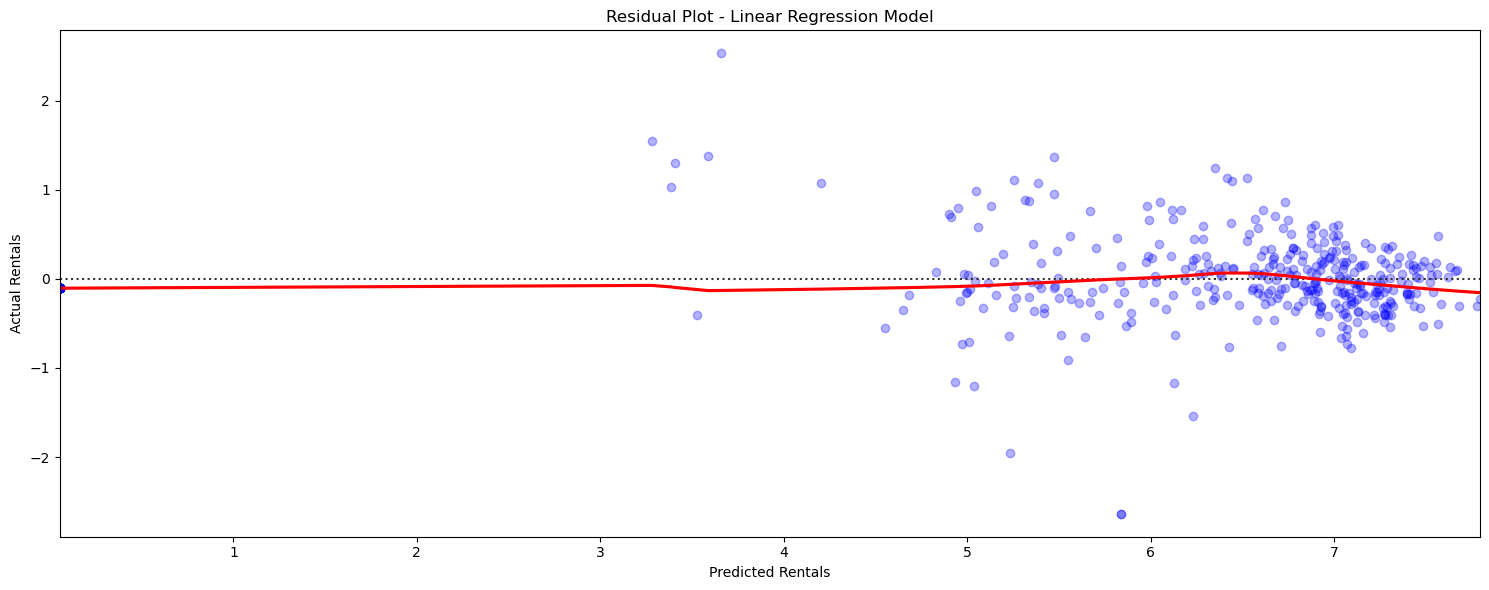

In [38]:
model(x         = df_x_fit, # x features from the fit model
      y         = df_y,     # log_Rentals
      scaling   = True,                                    # Scaling x-data
      model     = sklearn.linear_model.LinearRegression(), # Instantiating model
      name      = "Linear Regression",                     # Naming Model
      coeff     = True,                             # Outputting Coefficients
      residuals = True)                             # Plotting residuals

Unsurprisingly, a simple Ordinary Least Squares (OLS) model, trained on the training data and tested on the test data, performs similarly to the model trained on the entire training dataset in terms of fit. This observation underscores the efficacy of the Functioning Day transformation, as evidenced by the absence of residuals around zero predicted rentals. However, a significant variance in the range of predicted rentals from 3 to 6 log_Rentals is apparent, contributing to the model achieving a training score of 95.85% with a training-test gap of 0.73%. For an initial model, this performance is commendable, yet there is potential for improvement when compared with other models. Additionally, as anticipated, all coefficients deviate from zero, indicating that all employed features have explanatory value regarding the number of rentals.

<h4>Lasso Regression</h4>

In the context of Lasso regression, the alpha parameter emerges as the sole relevant hyperparameter, thereby rendering all others as fixed.

In [39]:
# setting hyperparameter grid
param_grid_lasso = {
    "alpha": np.arange(0.01,2,0.01)}

# performing hyperparameter tuning
hyperparamter_tuning(x = df_x_fit, # x features from the fit model
                     y = df_y,     # log_Rentals
                     model = sklearn.linear_model.Lasso( # instantiating model
                         fit_intercept = True,    # fixed
                         precompute    = False,   # fixed
                         copy_X        = True,    # fixed
                         max_iter      = 1000,    # fixed
                         tol           = 0.01,    # fixed
                         warm_start    = False,   # fixed
                         positive      = False,   # fixed
                         random_state  = 1836,    # fixed
                         selection     = "cyclic" # fixed
                     ), # selection of preselected hyperparameters
                     name = "Lasso Regression",     # naming model
                     parameters = param_grid_lasso, # using predefined grid
                     n = 3,          # output of solutions
                     scaling = True) # Scaling x-data


Tuned Lasso Regression Parameters  : {'alpha': 0.03}
Tuned Lasso Regression Training AUC: 0.9304

Parameters in 3 Best Models:
'alpha'= 0.03
'alpha'= 0.04
'alpha'= 0.05

    Model_Rank  Mean_Test_Score  SD_Test_Score     Parameters
73           1         0.930384       0.004907  'alpha'= 0.03
21           2         0.923240       0.005826  'alpha'= 0.04
13           3         0.913850       0.007070  'alpha'= 0.05


Model Name:     Lasso Regression
Train_Score:    0.9152
Test_Score:     0.9201
Train-Test Gap: 0.0049


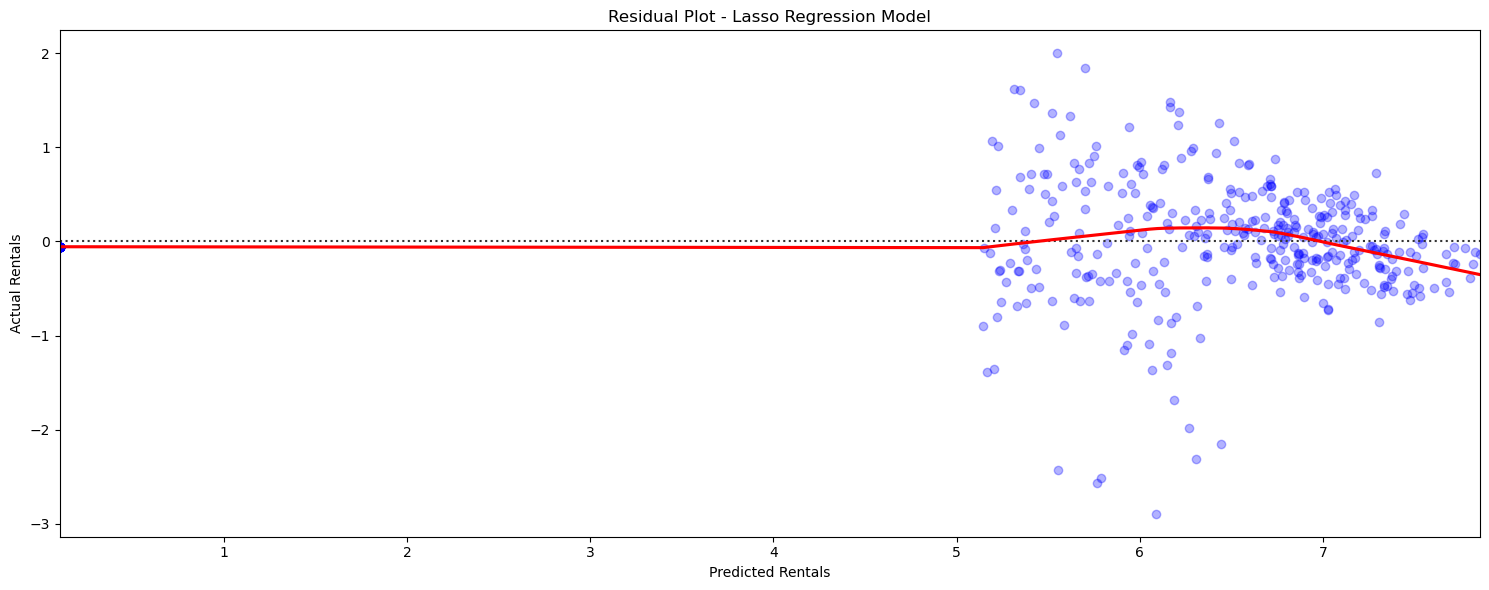

In [40]:
model(x     = df_x_fit, # x features from the fit model
      y     = df_y,     # log_Rentals
      scaling = True,   # Scaling x-data
      model = sklearn.linear_model.Lasso( # Specifying hyperparameters
                         alpha         = 0.03,   # variable
                         fit_intercept = True,   # fixed
                         precompute    = False,  # fixed
                         copy_X        = True,   # fixed
                         max_iter      = 1000,   # fixed
                         tol           = 0.0001, # fixed
                         warm_start    = False,  # fixed
                         positive      = True,   # fixed
                         random_state  = 1836,   # fixed
                         selection     = "cyclic"
                         ), # instantiating model
      name  = "Lasso Regression", # naming model
      # Suppressing coefficients and printing residuals
      coeff = False, residuals = True)

The hyper-tuned Lasso regression model exhibits a characteristic whereby it effectively nullifies the prediction of log_Rentals at all values up to 5, except 0. This attribute of the model contributes to a diminished discrepancy between training and testing performance, thereby enhancing its robustness. However, it is noteworthy that the model encounters significantly elevated error margins at the log_Rentals level of 6. Moreover, there is a pronounced deviation of the average error from zero, particularly at the higher end of the scale, compromising the model's predictive accuracy in these regions. Despite these limitations, the model retains commendable efficacy, with training and testing accuracy exceeding 90%.

<h4>Ridge Regression</h4>

An iterative process was implemented to ensure practical hyperparameter tuning, during which a select number of parameters demonstrated such significant influence that they were ultimately hardcoded.

In [41]:
param_grid_ridge = {
    "alpha": np.arange(0.1,5,0.01)
    }

# performing hyperparameter tuning
hyperparamter_tuning(x = df_x_fit, # x features from the fit model
                     y = df_y,     # log_Rentals
                     model = sklearn.linear_model.Ridge( # instantiating model
                         solver        = "auto", # fixed
                         random_state  = 1836,   # fixed
                         positive      = False,  # fixed
                         fit_intercept = True,   # fixed
                         copy_X        = False   # fixed
                     ), # selection of preselected hyperparameters
                     name = "Ridge Regression",     # naming model
                     parameters = param_grid_ridge, # using predefined grid
                     n = 3,          # output of solutions
                     scaling = True) # Scaling x-data


Tuned Ridge Regression Parameters  : {'alpha': 0.6199999999999998}
Tuned Ridge Regression Training AUC: 0.9542

Parameters in 3 Best Models:
'alpha'= 0.6199999999999998
'alpha'= 0.5699999999999997
'alpha'= 0.5499999999999998

    Model_Rank  Mean_Test_Score  SD_Test_Score                   Parameters
96           1         0.954192       0.003233  'alpha'= 0.6199999999999998
38           2         0.954190       0.003248  'alpha'= 0.5699999999999997
41           3         0.954187       0.003255  'alpha'= 0.5499999999999998


Model Name:     Ridge Regression
Train_Score:    0.9578
Test_Score:     0.9524
Train-Test Gap: 0.0054


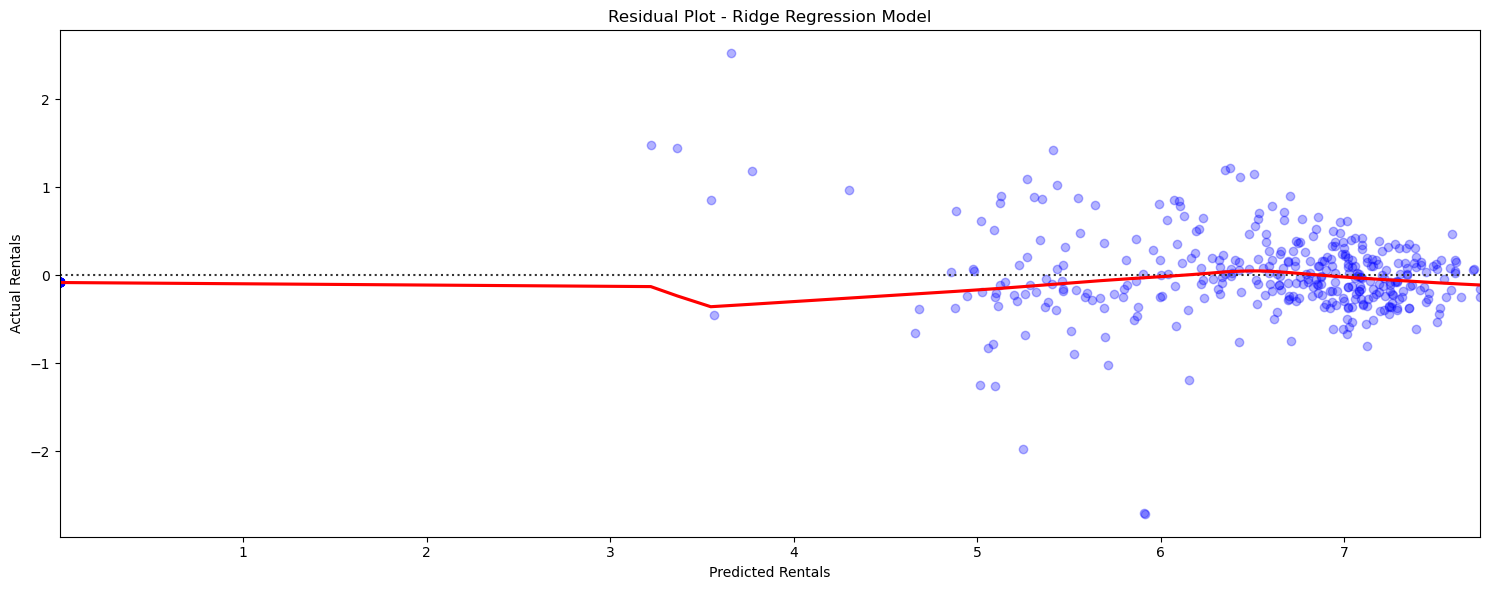

In [42]:
model(x     = df_x_fit, # x features from the fit model
      y     = df_y,     # log_Rentals
      scaling = True,   # Scaling x-data
      model = sklearn.linear_model.Ridge( # selection of hyperparameters
          solver        = "auto", # fixed
          random_state  = 1836,   # fixed
          positive      = False,  # fixed
          fit_intercept = True,   # fixed
          copy_X        = False,  # fixed
          alpha         = 0.62,   # variable
          ), # instantiating model
      name  = "Ridge Regression", # naming the model
      # Suppressing coefficients and printing residuals      
      coeff = False, residuals = True)

The comparative analysis of ridge regression against lasso and ordinary least squares regression models shows that ridge regression attains a superior performance metric. Although the discrepancy between training and testing scores is marginally more significant in ridge regression than in lasso regression, it is compensated by the former's significantly enhanced explanatory power. However, it is essential to highlight that the mean squared error (MSE) often exhibits substantial deviation, typically underestimating the number of log_Rentals compared to actual figures. Notably, predictions exceeding a value of 6 - recalling the distribution depicted in the log-transformed rentals histogram at an earlier stage - represent most of the data points, demonstrating the model's commendable predictive capability. This suggests that, despite its limitations, the ridge regression model exhibits a high level of accuracy for the bulk of the dataset, underscoring its effectiveness.

<h4>Elastic Net Regression</h4>

In [43]:
# creating a hyperparameter grid
param_grid_sgd = {
    "n_iter_no_change": np.arange(20, 60, 1),
    "eta0": np.arange(1, 101, 1), 
    "alpha": np.arange(0,0.05,0.001)}

# performing hyperparameter tuning
hyperparamter_tuning(
    x = df_x_fit, # x features from the fit model
    y = df_y,     # log_Rentals
    model = sklearn.linear_model.SGDRegressor( # setting hyperparameters 
          random_state        = 1836,                          # fixed
          warm_start          = False,                         # fixed
          verbose             = 0,                             # fixed
          tol                 = 0,                             # fixed
          shuffle             = False,                         # fixed
          power_t             = 0.85,                          # fixed
          penalty             = "elasticnet",                  # fixed
          max_iter            = 100,                           # fixed
          loss                = "huber",                       # fixed
          learning_rate       = "invscaling",                  # fixed
          l1_ratio            = 0,                             # fixed
          fit_intercept       = True,                          # fixed
          epsilon             = 1,                             # fixed
          early_stopping      = False,                         # fixed
          average             = False,                         # fixed
          ), # instantiating model
    name = "Elastic Net",      # naming the model
    parameters = param_grid_sgd, # using predefined grid
    n = 3,          # output of solutions
    scaling = True) # Scaling x-data


Tuned Elastic Net Parameters  : {'n_iter_no_change': 46, 'eta0': 2, 'alpha': 0.024}
Tuned Elastic Net Training AUC: 0.9104

Parameters in 3 Best Models:
'n_iter_no_change'= 46, 'eta0'= 2, 'alpha'= 0.024
'n_iter_no_change'= 39, 'eta0'= 2, 'alpha'= 0.043000000000000003
'n_iter_no_change'= 24, 'eta0'= 2, 'alpha'= 0.014

    Model_Rank  Mean_Test_Score  SD_Test_Score                                         Parameters
75           1         0.910417       0.008188  'n_iter_no_change'= 46, 'eta0'= 2, 'alpha'= 0.024
61           2         0.908721       0.008433  'n_iter_no_change'= 39, 'eta0'= 2, 'alpha'= 0....
35           3         0.908701       0.007702  'n_iter_no_change'= 24, 'eta0'= 2, 'alpha'= 0.014


Model Name:     Elastic Net Regression
Train_Score:    0.9482
Test_Score:     0.9409
Train-Test Gap: 0.0073


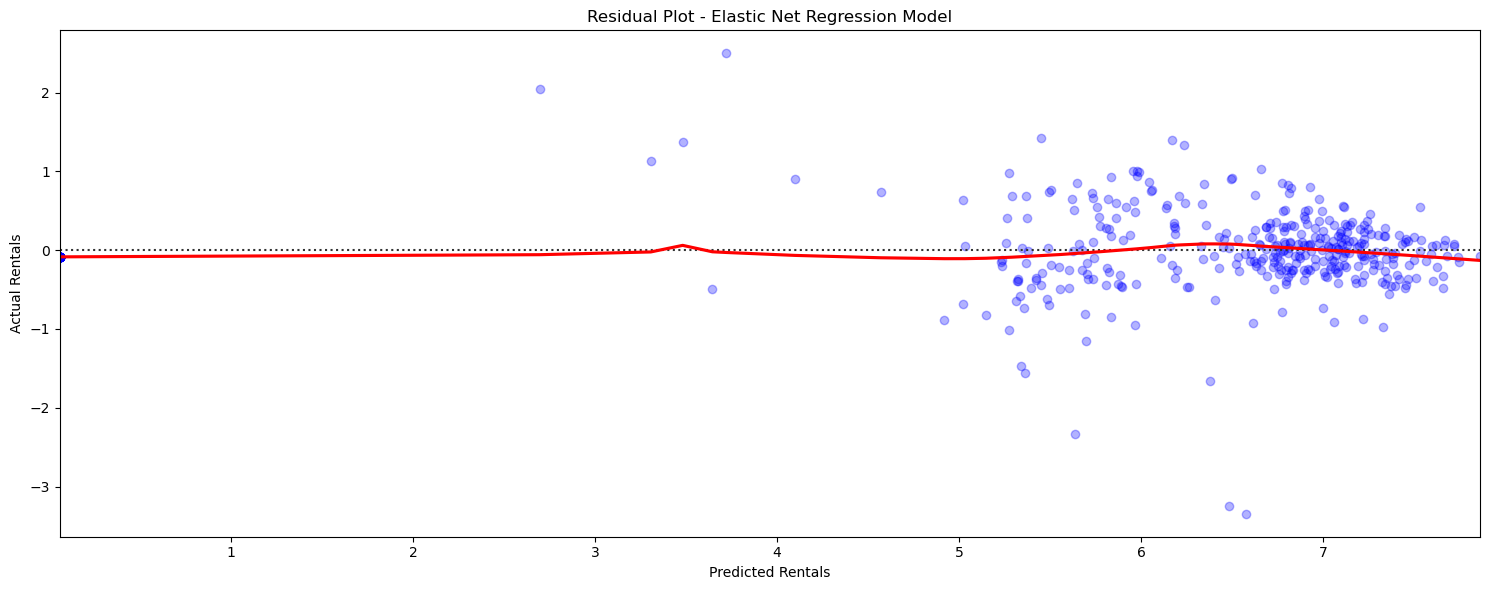

In [44]:
model(x       = df_x_fit, # x features from the fit model
      y       = df_y,     # log_Rentals
      scaling = True,   # Scaling x-data
      model   = sklearn.linear_model.SGDRegressor( # setting hyperparameters 
          random_state        = 1836,                          # fixed
          warm_start          = False,                         # fixed
          verbose             = 0,                             # fixed
          tol                 = 0,                             # fixed
          shuffle             = False,                         # fixed
          power_t             = 0.85,                          # fixed
          penalty             = "elasticnet",                  # fixed
          n_iter_no_change    = 46,                            # variable
          max_iter            = 100,                           # fixed
          loss                = "huber",                       # fixed
          learning_rate       = "invscaling",                  # fixed
          l1_ratio            = 0,                             # fixed
          fit_intercept       = True,                          # fixed
          eta0                = 2,                             # variable
          epsilon             = 1,                             # fixed
          early_stopping      = False,                         # fixed
          average             = False,                         # fixed
          alpha               = 0.024                          # variable
          ), # instantiating model
      # Suppressing coefficients and printing residuals
      name  = "Elastic Net Regression", # naming model
      # Suppressing coefficients and printing residuals
      coeff = False , residuals = True)

Elastic Net regression deviates from the traditional linear regression approach. However, the same deviation pattern is observed in the residual plot. Consistent errors persist, particularly in the prediction of log_Rentals within the range of 2 to 6. Although the model demonstrates a commendable accuracy in predicting higher rental values, the mean error deteriorates as the predictions reach extremely high values. Despite boasting a narrow train-test gap of 0.7%, the model's performance falls short compared to the Ridge regression model.

<h4>K-Nearest Neighbours</h4>

The primary factor of the k-Nearest Neighbors (kNN) model is the number of neighbors.

In [45]:
# creating a hyperparameter grid
param_grid_knn = {"n_neighbors": np.arange(1, 400, 1)}

# performing hyperparameter tuning
hyperparamter_tuning(x = df_x_fit, # x features from the fit model
                     y = df_y,     # log_Rentals
                     model = KNeighborsRegressor( # instantiating model
                         weights     = "distance",
                         leaf_size   = 10, # with predefined hyper-parameters
                         algorithm   = "auto"),
                         name = "KNN",                # naming model
                         parameters = param_grid_knn, # using predefined grid
                         n = 3,                       # output of solutions
                         scaling = True)              # Scaling x-data


Tuned KNN Parameters  : {'n_neighbors': 3}
Tuned KNN Training AUC: 0.9521

Parameters in 3 Best Models:
'n_neighbors'= 3
'n_neighbors'= 8
'n_neighbors'= 14

    Model_Rank  Mean_Test_Score  SD_Test_Score         Parameters
80           1         0.952074       0.005298   'n_neighbors'= 3
81           2         0.950360       0.004415   'n_neighbors'= 8
5            3         0.948303       0.003503  'n_neighbors'= 14


Model Name:     K-Nearest Neighbors
Train_Score:    1.0
Test_Score:     0.9663
Train-Test Gap: 0.0337


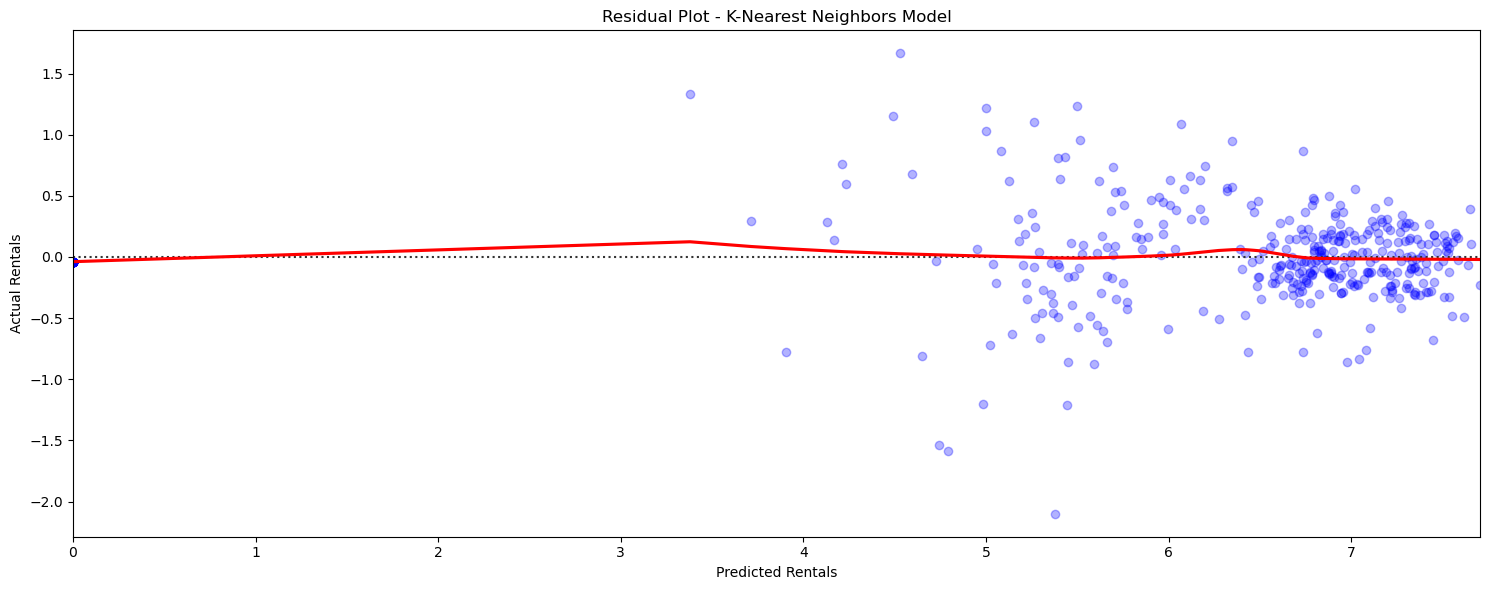

In [46]:
model(x       = df_x_fit, # x features from the fit model
      y       = df_y,     # log_Rentals
      scaling = True,     # Scaling x-data
      model   = KNeighborsRegressor(weights     = "distance", # selecting
                                    p           = 1,   # hyper-parameters
                                    n_neighbors = 8,
                                    leaf_size   = 10,
                                    algorithm   = "auto"
                                   ),  # instantiating model
      name   = "K-Nearest Neighbors",  # naming model
      residuals = True)                # printing residuals

With a count of eight neighbors, an extremely precise prediction is achievable. A training score of 1, combined with a test score of 96.6%, results in a train-test gap of 3.4%, which is remarkably strong. The residuals plot reveals only minimal deviation in the previously problematic area around 3-4 log_rentals, where the error terms are, on average, slightly overestimated. Particularly in the realm of high rental numbers, the model exhibits high accuracy, as evidenced by the scatter plot, which shows points clustering near zero deviation. The only criticism to be made concerns the relatively high deviations observed in the range of 3 to 5 log_rentals.

<h4>Decision Tree Regressor</h4>

The Decision Tree Regressor offers considerable flexibility for hyperparameter tuning. This study will constrain the depth to 8.

In [47]:
# creating a hyperparameter grid
param_grid_tree = {"splitter": ["best", "random"],
                   "min_weight_fraction_leaf": np.arange(0, 0.003, 0.001),
                   "min_samples_split": np.arange(10, 20, 1),
                   "min_samples_leaf": np.arange(1, 3, 1),
                   "min_impurity_decrease": np.arange(0.25,1.25,0.001),
                   "max_leaf_nodes": np.arange(30, 60, 1),
                   "ccp_alpha": np.arange(0,0.005,0.001)}

# performing hyperparameter tuning
hyperparamter_tuning(x = df_x_fit, # x features from the fit model
                     y = df_y,     # log_Rentals
                     model = DecisionTreeRegressor( # selecting
                         random_state = 1836,       # hyper-parameters
                         criterion    = "friedman_mse",
                         splitter     = "best",
                         max_features = None,
                         max_depth    = 8),
                     name = "DTR",
                     parameters = param_grid_tree,
                     n = 3,          # output of solutions
                     scaling = True) # Scaling x-data


Tuned DTR Parameters  : {'splitter': 'best', 'min_weight_fraction_leaf': 0.001, 'min_samples_split': 14, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.6350000000000003, 'max_leaf_nodes': 56, 'ccp_alpha': 0.002}
Tuned DTR Training AUC: 0.9587

Parameters in 3 Best Models:
'splitter'= 'best', 'min_weight_fraction_leaf'= 0.001, 'min_samples_split'= 14, 'min_samples_leaf'= 1, 'min_impurity_decrease'= 1.0810000000000008, 'max_leaf_nodes'= 45, 'ccp_alpha'= 0.002
'splitter'= 'best', 'min_weight_fraction_leaf'= 0.001, 'min_samples_split'= 14, 'min_samples_leaf'= 2, 'min_impurity_decrease'= 0.6350000000000003, 'max_leaf_nodes'= 56, 'ccp_alpha'= 0.002
'splitter'= 'best', 'min_weight_fraction_leaf'= 0.002, 'min_samples_split'= 19, 'min_samples_leaf'= 2, 'min_impurity_decrease'= 0.7990000000000005, 'max_leaf_nodes'= 33, 'ccp_alpha'= 0.002

    Model_Rank  Mean_Test_Score  SD_Test_Score                                         Parameters
66           1         0.958664       0.004888  'splitter

Model Name:     Decision Tree Regressor
Train_Score:    0.9724
Test_Score:     0.9568
Train-Test Gap: 0.0156


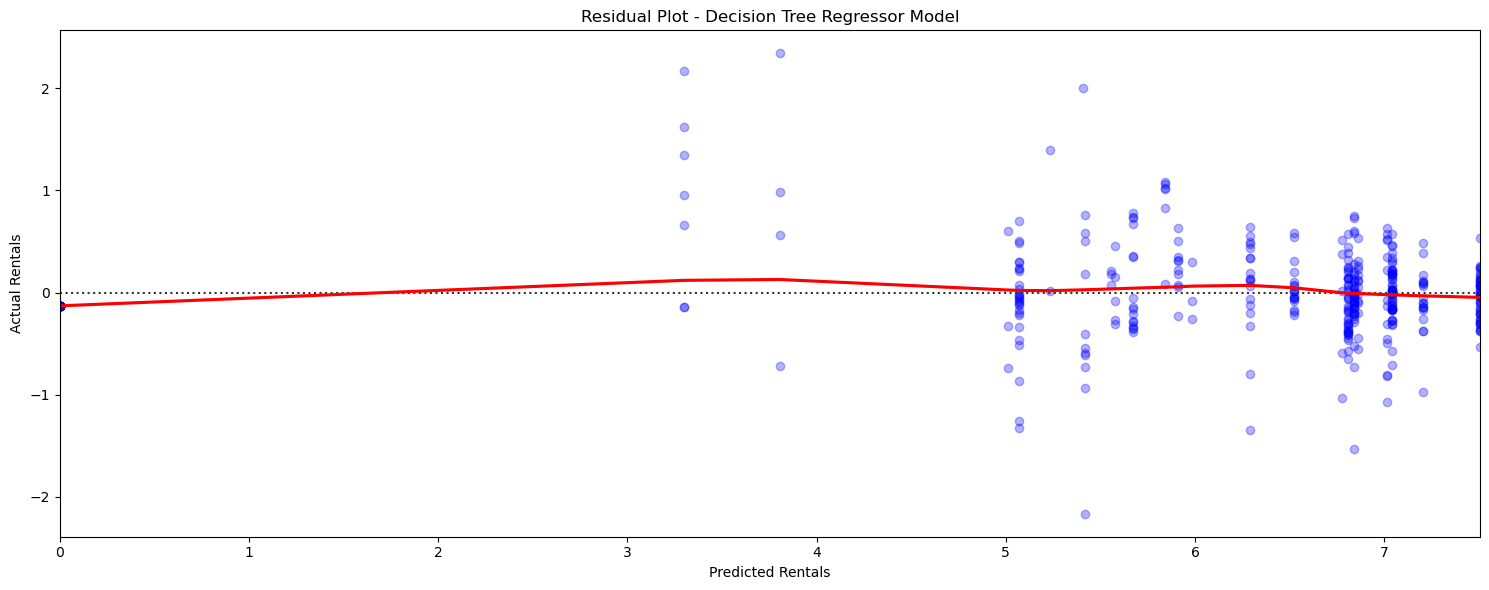

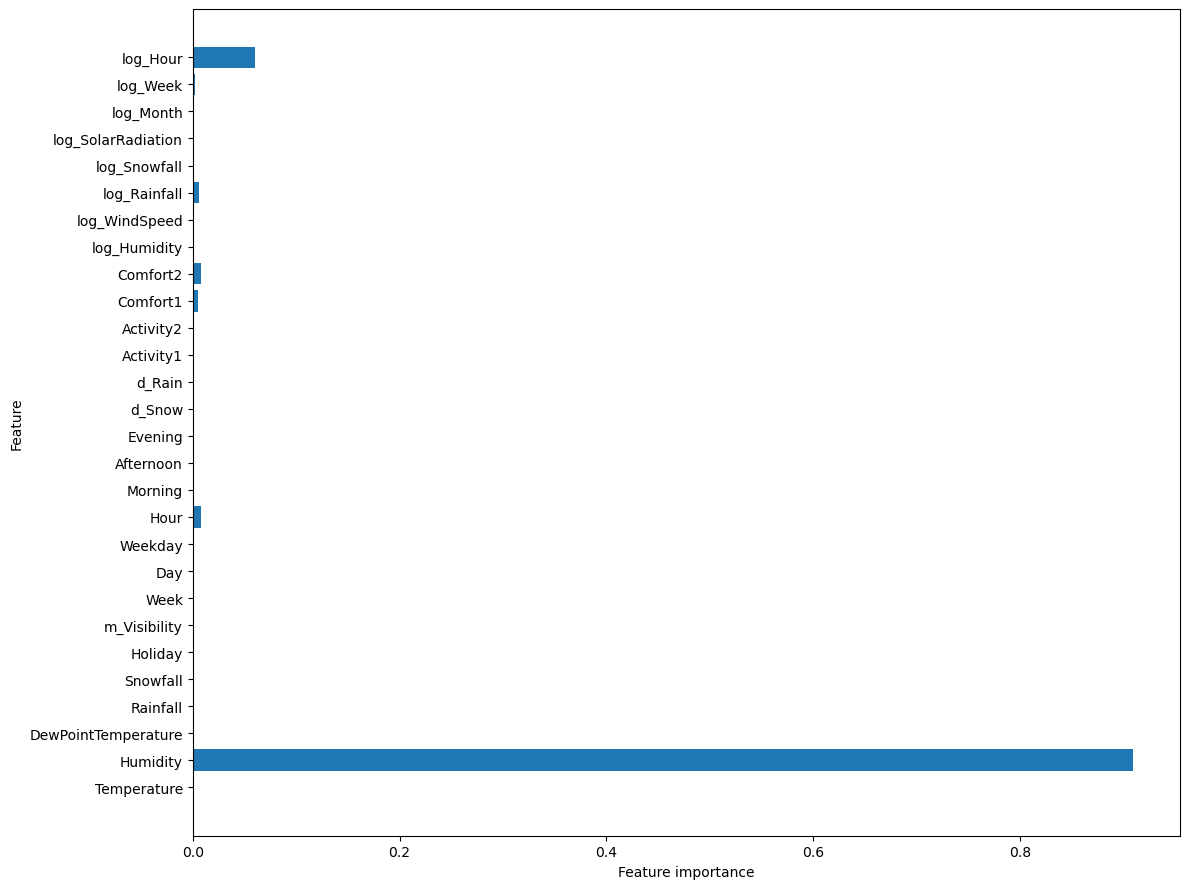

In [48]:
# tuned
model(x       = df_x_fit,
      y       = df_y, # log_Rentals
      scaling = True, #
      model = DecisionTreeRegressor(random_state             = 1836,
                                    splitter                 = "best",
                                    min_weight_fraction_leaf = 0.001,
                                    min_samples_split        = 14,
                                    min_samples_leaf         = 1,
                                    min_impurity_decrease    = 1.081,
                                    max_leaf_nodes           = 45,
                                    max_features             = None,
                                    max_depth                = 8,
                                    criterion                = "friedman_mse",
                                    ccp_alpha                = 0.002),  # instantiating model
      name  = "Decision Tree Regressor",
      
      residuals = True, tree = False, feature_importance = True)

The analysis of the residual plot reveals a significant drawback of the Decision Tree model: it categorizes observations into distinct buckets, where they remain fixed. This segmentation implies that once an observation is assigned to a bucket, it is not further subdivided, even though additional subdivisions could enhance accuracy. However, as precision optimization is not the primary objective, the depth of the tree is intentionally limited. This results in a large number of observations being assigned the same value. While this approach generally offers a reasonable range of predictions in most training scenarios, significant deviations are observed between 3 and 5.5 in log_Rentals. Despite these limitations, the model achieves a test score of 95.7%, ranking it as the second-best model evaluated. 

Interestingly, the analysis also highlights which features exert the most significant influence on rentals. Humidity emerges as a major factor, followed by the time of day. Engineered features, such as the Comfort Level, also play a minor role in the decision-making process for bike rentals. However, it is crucial to note that prior to modeling, all features were multiplied by the Functioning Day variable. This manipulation amplifies the perceived effect of these features beyond their actual impact. Given that the primary goal is to predict the number of rentals, the model effectively summarizes that the cyclist's comfort significantly influences the likelihood of renting a bike.

<h3>Final Model Selection</h3><br>

In [49]:
model(x       = df_x_fit, # x features from the fit model
      y       = df_y,     # log_Rentals
      scaling = True,     # Scaling x-data
      model   = KNeighborsRegressor(weights     = "distance", # selecting
                                    p           = 1,   # hyper-parameters
                                    n_neighbors = 8,
                                    leaf_size   = 10,
                                    algorithm   = "auto"
                                   ),  # instantiating model
      name   = "K-Nearest Neighbors",  # naming model
      residuals = False)               # printing residuals

Model Name:     K-Nearest Neighbors
Train_Score:    1.0
Test_Score:     0.9663
Train-Test Gap: 0.0337


The K-Nearest Neighbors model is selected as the best model, as it exhibits the highest test score and an average error term tending towards zero.

In [50]:
# exporting data with engineered features to excel
df_adj.to_excel("clawiese.xlsx", index = False, engine = "openpyxl")